In [513]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

### 情景分析：
    HomeCredit是一家专注于为无银行信用背景的个人提供借贷服务的金融公司。本项目的核心任务是建立一个模型，通过分析和利用包括借贷人的银行信用评分、个人财产（如房产和车辆）、教育背景、职业状况，以及家庭情况等多元化信息，来预测这位借贷申请人是否会进行下一次的借贷行为。这是一个分类问题，旨在将借款人分为可能再次借款和可能不再借款两类。

    该公司目前拥有借贷申请记录、信用记录和先前的借贷记录等多个数据集。这些数据集通过每笔借款的唯一认证号相互关联，形成了一个完整的信息体系，提供了丰富的数据资源并有助于更准确地预测借款人的未来行为。

### 处理思路：
    为了解决这一分类问题，我打算采用LightGBM或XGBoost这两种的梯度提升（Gradient Boosting Decision Tree）算法。具体的处理步骤将如下：

    1. 数据整合：首先，我将把所有的数据集合并到含有目标变量的主要借贷申请表格中，从而形成一个完整的数据集，便于数据的输入和模型的评估；

    2. 数据探索：然后，我会利用箱线图和变量的统计数值对数据进行探索，寻找并处理异常值和缺失值；

    3. 特征工程：

        a. 特征衍生：根据上下文和各变量的含义，我将衍生出新的特征，目标是从原始数据中提取出对模型训练有用的信息；

        b. 特征转换：针对分类变量，我将采用独热编码（One-Hot Encoding）来进行处理，以便于模型的理解和处理；

    4. 数据划分：为了有效评估模型的性能，我将整个数据集划分为训练集和测试集。训练集将用于模型的训练和参数优化，而测试集则将用于评估模型的最终性能；

    5. 模型训练：

    模型选择：我选择用LightGBM / XGBoost作为模型，并利用训练集数据进行训练。训练过程中，我将会对模型参数进行细致的调整和优化；
        a. 参数优化：我计划使用网格搜索（Grid Search）/随机搜索（Random Search）/贝叶斯优化（Bayesian Optimization）来确定最优的超参数；

        b. 模型评估：最后，我将利用测试集数据来评估模型的性能。我将主要使用AUC/ROC曲线作为模型性能的评价指标，以展示模型的预测效果。

### 步骤1.合并数据集

首先，对于一条借贷认证号存在多条记录的情况（可能由于记录周期较短或个人过去存在多次的借贷行为），

为了方便，我定义了一个对于一个数据集里的数值类&类型类变量去分类讨论，以获得处理方法的方程

喂入数据集（df），根据数据集里的不同变量类型吐出不同的处理方法记录以便于调用

In [514]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:  #少于等于五类的变量化为类型变量
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)     #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

### 数据集1. previous_application

In [515]:
pre_app = pd.read_csv('previous_application.csv')
pre_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


初步了解数据集变量

In [516]:
pre_app.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

类型类变量

In [517]:
pre_num, pre_cat = get_cols(pre_app)
pre_cat

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'NFLAG_LAST_APPL_IN_DAY',
 'NFLAG_INSURED_ON_APPROVAL']

数值类变量

In [518]:
pre_num

['DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'AMT_GOODS_PRICE',
 'AMT_APPLICATION',
 'DAYS_FIRST_DRAWING',
 'RATE_INTEREST_PRIVILEGED',
 'CNT_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'DAYS_FIRST_DUE',
 'AMT_DOWN_PAYMENT',
 'RATE_DOWN_PAYMENT',
 'HOUR_APPR_PROCESS_START',
 'DAYS_TERMINATION']

将 类型变量 用One-Hot 转为 离散的 数值类变量。

In [519]:
pre_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [520]:
pre_cat

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'NFLAG_LAST_APPL_IN_DAY',
 'NFLAG_INSURED_ON_APPROVAL']

In [521]:
count = 0

for col in pre_cat:
    count += pre_app[col].unique().shape[0]

count

150

In [522]:
pre_app_encoded = pre_app.copy()  #创建一个副本以保留原始数据

for col in pre_cat:
    one_hot_encoded = pd.get_dummies(pre_app[col], prefix=col)
    pre_app_encoded = pd.concat([pre_app_encoded, one_hot_encoded], axis=1)
    pre_app_encoded.drop(col, axis=1, inplace=True)

pre_app_encoded

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,0.000000,0.182832,...,False,False,True,False,False,False,False,True,True,False
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,0.0,267295.5,12,0.000000,NaN,...,True,False,False,False,False,False,False,True,True,False
1670210,2357031,334635,6622.020,87750.0,64291.5,29250.0,87750.0,15,0.340554,NaN,...,True,False,False,False,False,False,False,True,True,False
1670211,2659632,249544,11520.855,105237.0,102523.5,10525.5,105237.0,12,0.101401,NaN,...,False,False,False,False,False,False,False,True,True,False
1670212,2785582,400317,18821.520,180000.0,191880.0,NaN,180000.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True


寻找/处理数值类异常值

In [523]:
for num_col in pre_num:
    print('-------------------')
    print(num_col)
    print(pre_app_encoded[num_col].describe())

-------------------
DAYS_LAST_DUE_1ST_VERSION
count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64
-------------------
DAYS_LAST_DUE
count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64
-------------------
AMT_ANNUITY
count    1.297979e+06
mean     1.595512e+04
std      1.478214e+04
min      0.000000e+00
25%      6.321780e+03
50%      1.125000e+04
75%      2.065842e+04
max      4.180581e+05
Name: AMT_ANNUITY, dtype: float64
-------------------
AMT_CREDIT
count    1.670213e+06
mean     1.961140e+05
std      3.185746e+05
min      0.000000e+00
25%      2.416050e+04
50%      8.054100e+04
75%      2.164185e+05
max      6.905160e+06
Name: AMT_CREDIT, d

观察这些不同变量的统计数值，似乎AMT_DOWN_PAYMENT（复数最小值）、RATE_DOWN_PAYMENT（复数最小值）、
DAYS_FIRST_DRAWING（365243）、DAYS_FIRST_DUE（365243）、DAYS_LAST_DUE_1ST_VERSION（365243）、DAYS_LAST_DUE（365243）、DAYS_TERMINATION（365243）较为异常。

其中，365243这个数值出现了很多次，拉高了很多变量的平均值以及离散程度，主要是后5个日期变量。

首先，处理AMT_DOWN_PAYMENT、RATE_DOWN_PAYMENT的异常负值问题（最小值为负）。

In [524]:
abnormal = ['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT',
            'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

abnormal[:2]

['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT']

In [525]:
abnormal = ['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT',
            'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

for potent in abnormal[:2]:
    rows = pre_app_encoded[pre_app_encoded[potent] < 0][potent]
    print('-----------------')
    print(potent)
    print('# of cases =', len(rows))
    print(rows)

    pre_app_encoded.loc[pre_app_encoded[potent] < 0, potent] = np.nan   #略去异常值的记录

    print('----处理后----')    #检查
    print(pre_app_encoded[pre_app_encoded[potent] < 0][potent])

-----------------
AMT_DOWN_PAYMENT
# of cases = 2
368107    -0.90
1519595   -0.45
Name: AMT_DOWN_PAYMENT, dtype: float64
----处理后----
Series([], Name: AMT_DOWN_PAYMENT, dtype: float64)
-----------------
RATE_DOWN_PAYMENT
# of cases = 2
368107    -0.000014
1519595   -0.000015
Name: RATE_DOWN_PAYMENT, dtype: float64
----处理后----
Series([], Name: RATE_DOWN_PAYMENT, dtype: float64)


处理365243（视为录入错误）。

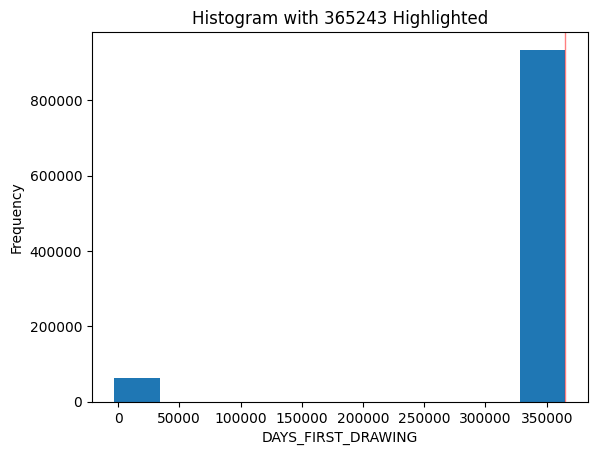

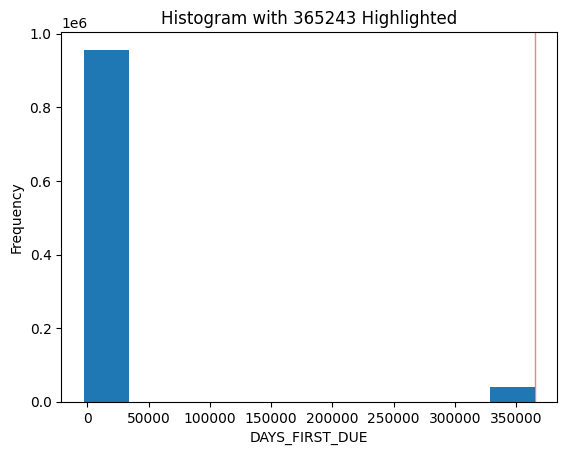

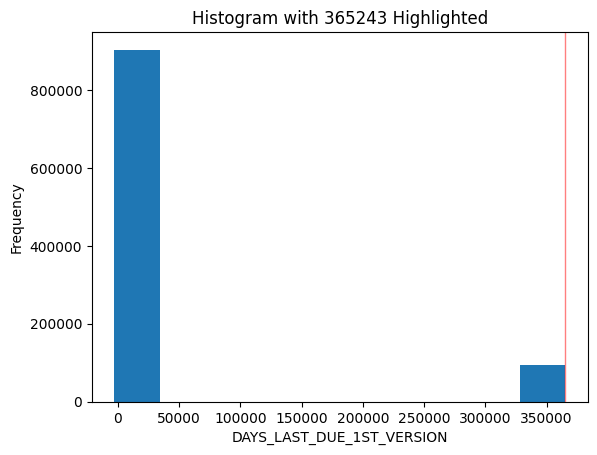

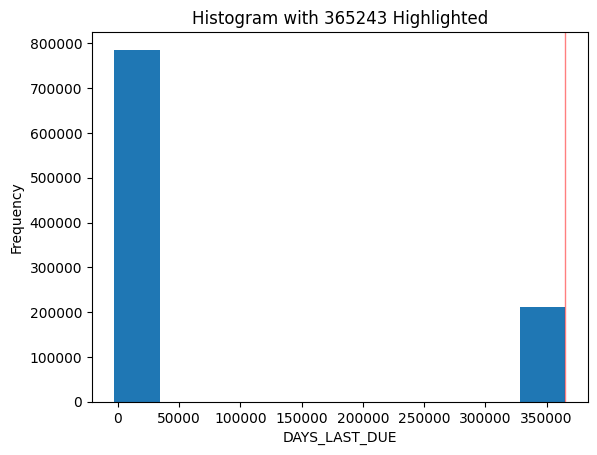

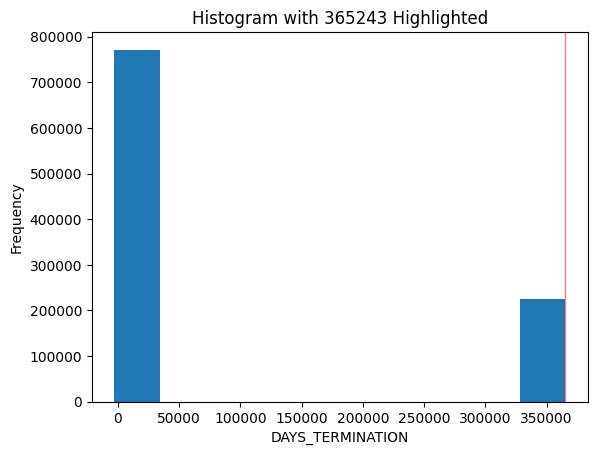

In [526]:
list365243 = abnormal[2:]
highlight_value = 365243  # 要高亮显示的特定值

for col365 in list365243:
    plt.hist(pre_app_encoded[col365])
    plt.axvspan(highlight_value - 0.5, highlight_value + 0.5, color='red', alpha=0.5)     # 高亮显示特定值的区域

    plt.xlabel(col365)
    plt.ylabel('Frequency')
    plt.title('Histogram with 365243 Highlighted')

    plt.show()

可知，365243均为各个目标变量的最大值（异常），这里化为NaN。

In [527]:
for col365 in list365243:
    pre_app_encoded.loc[pre_app_encoded[col365] == 365243, col365] = np.nan

In [528]:
for col365 in list365243:
    print('-------------------')
    print(col365)
    print(pre_app_encoded[col365].describe())

-------------------
DAYS_FIRST_DRAWING
count    62705.000000
mean     -1035.246791
std        922.710316
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64
-------------------
DAYS_FIRST_DUE
count    956504.000000
mean      -1106.583027
std         790.703113
min       -2892.000000
25%       -1676.000000
50%        -874.000000
75%        -459.000000
max          -2.000000
Name: DAYS_FIRST_DUE, dtype: float64
-------------------
DAYS_LAST_DUE_1ST_VERSION
count    903285.000000
mean       -677.158175
std         923.601152
min       -2801.000000
25%       -1359.000000
50%        -480.000000
75%          -2.000000
max        2389.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64
-------------------
DAYS_LAST_DUE
count    785928.000000
mean       -996.179128
std         752.703178
min       -2889.000000
25%       -1566.000000
50%        -801.000000
75%        -353.000000
max          -2

为什么DAYS_LAST_DUE_1ST_VERSION的最大值（2389.000000）为正，而且其他数值为复？

In [529]:
len(pre_app_encoded[pre_app_encoded['DAYS_LAST_DUE_1ST_VERSION']>0])

224392

似乎对于DAYS_LAST_DUE_1ST_VERSION这个变量，其数值为正有很多例，故这里视为正常不做处理。

进一步观察异常值。

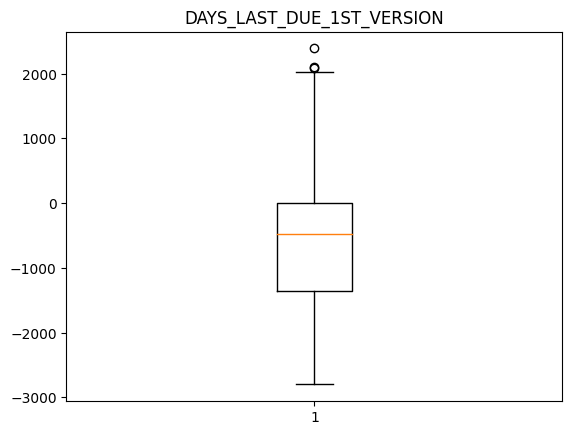

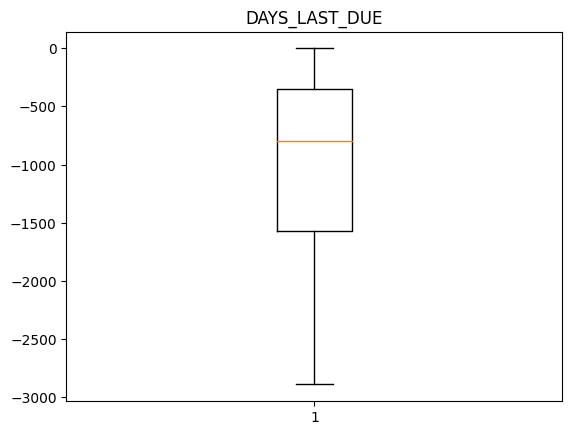

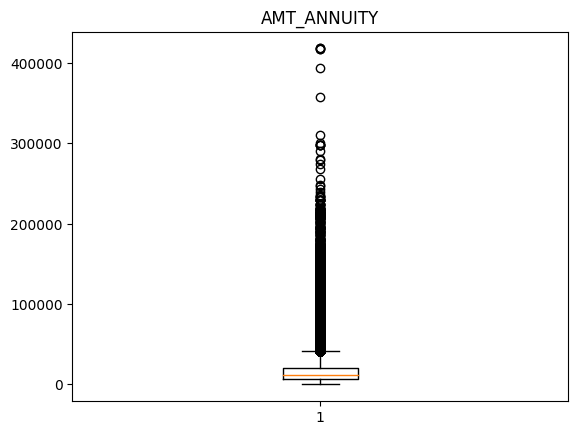

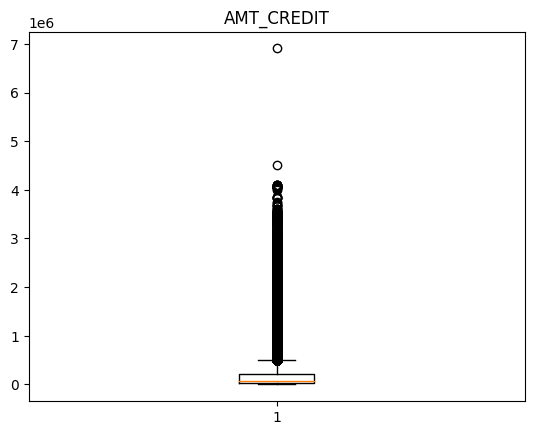

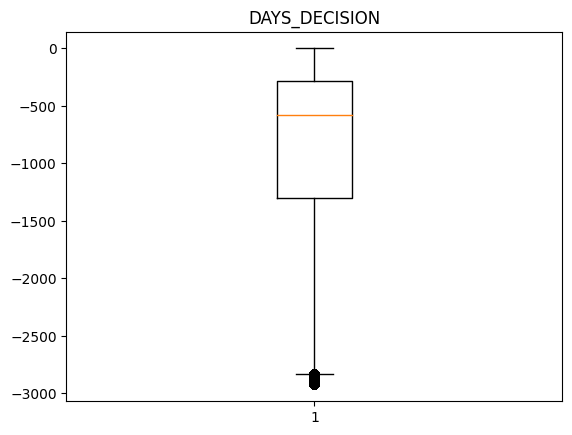

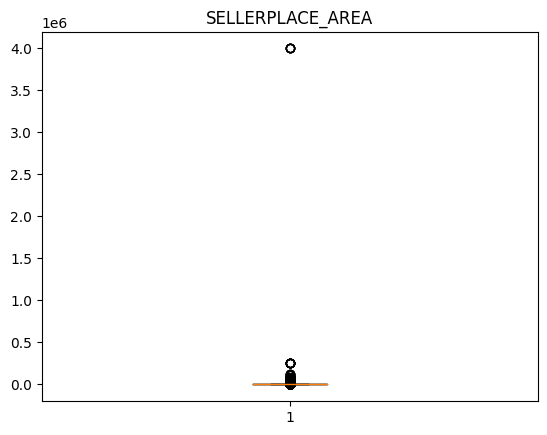

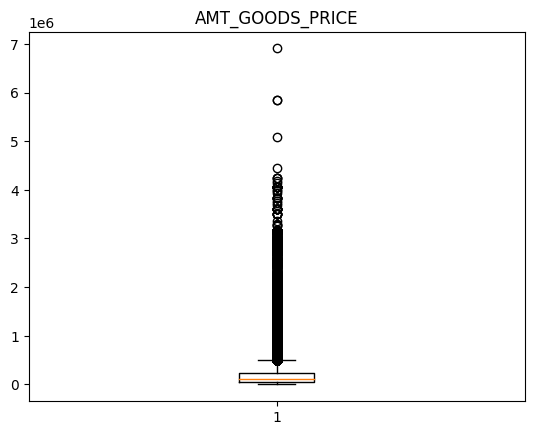

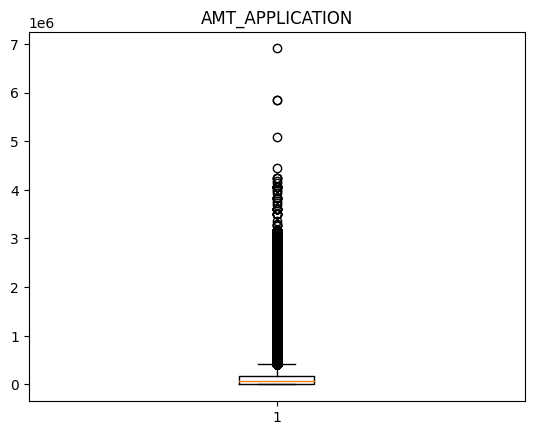

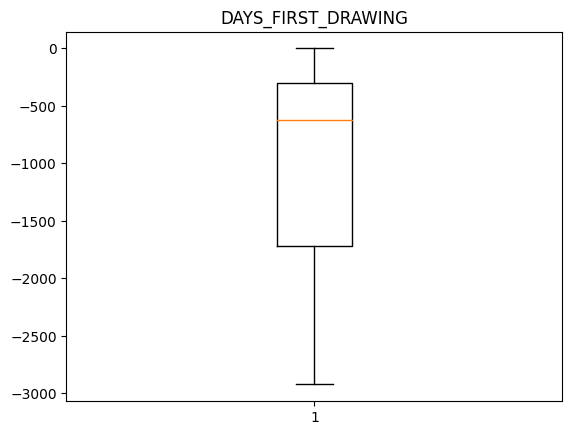

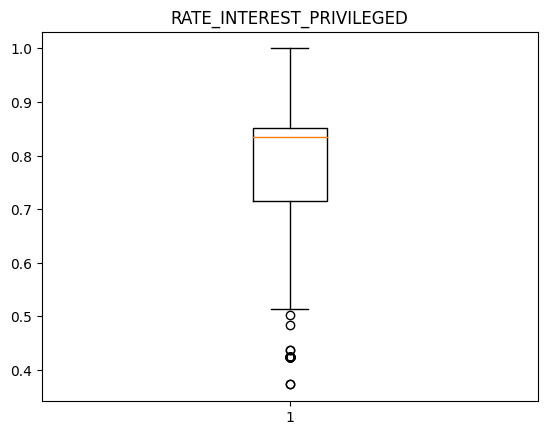

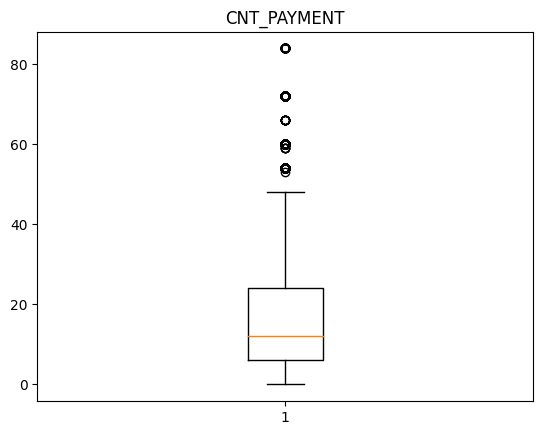

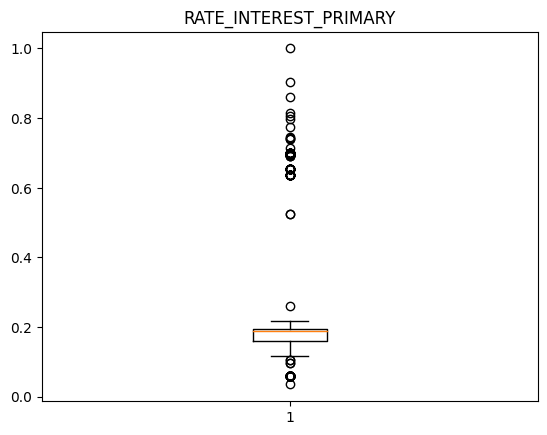

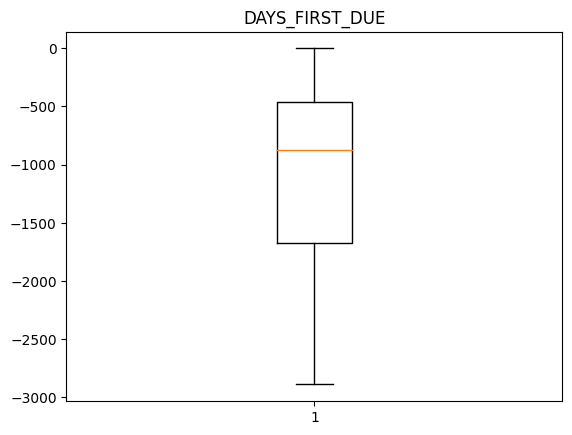

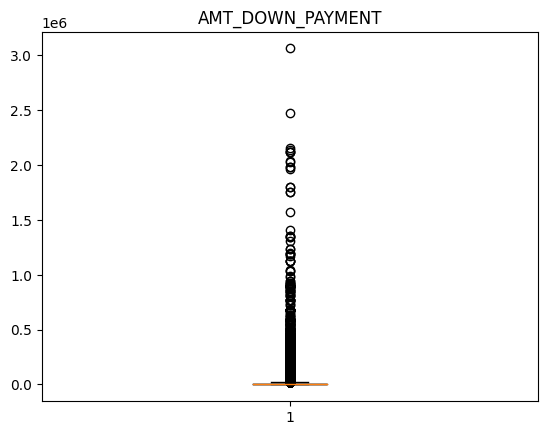

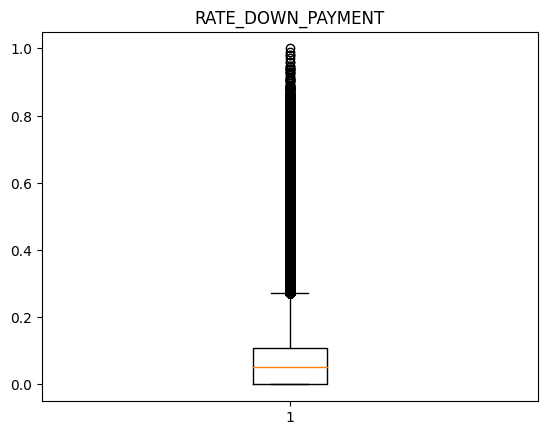

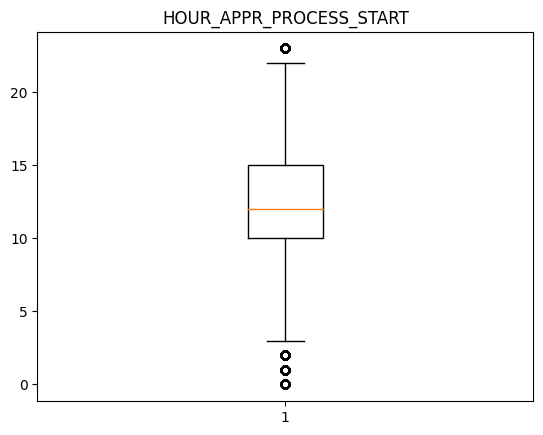

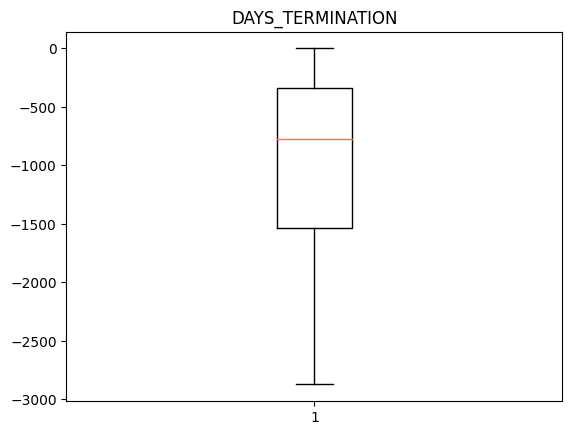

In [530]:
for num_col in pre_num:
    plt.boxplot(pre_app_encoded[num_col].dropna())   
    plt.title(num_col)
    plt.show()

SELLERPLACE_AREA怎么回事？为什么有一个极大值（4000000）？

In [531]:
pre_app_encoded[pre_app_encoded['SELLERPLACE_AREA'] == 4000000]

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
151,2783413,269324,5775.615,128205.0,128205.0,0.0,128205.0,20,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
157014,2094519,392616,19317.465,428800.5,428800.5,0.0,428800.5,20,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
310061,2403159,450405,3748.590,83209.5,83209.5,0.0,83209.5,19,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
919667,1125247,228186,2887.830,64102.5,64102.5,0.0,64102.5,18,0.0,NaN,...,False,True,False,False,False,False,False,True,True,False
1427909,1993482,390387,14535.180,121450.5,132138.0,0.0,121450.5,13,0.0,NaN,...,True,False,False,False,False,False,False,True,True,False


个例不足，视为异常，化为NaN。

In [532]:
pre_app_encoded.loc[pre_app_encoded['SELLERPLACE_AREA'] == 4000000, 'SELLERPLACE_AREA'] = np.nan

In [533]:
pre_app_encoded[pre_app_encoded['SELLERPLACE_AREA'] == 4000000]  #检查

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0


最后检查。

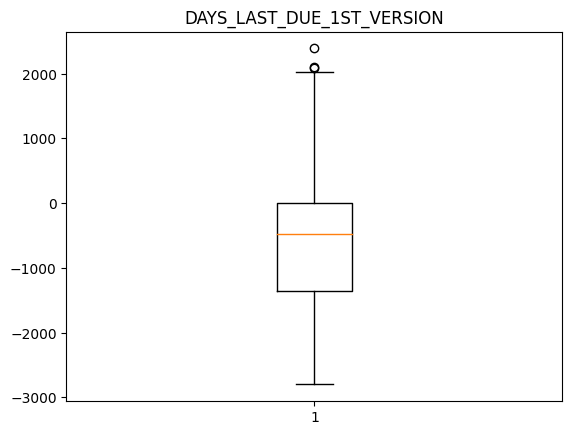

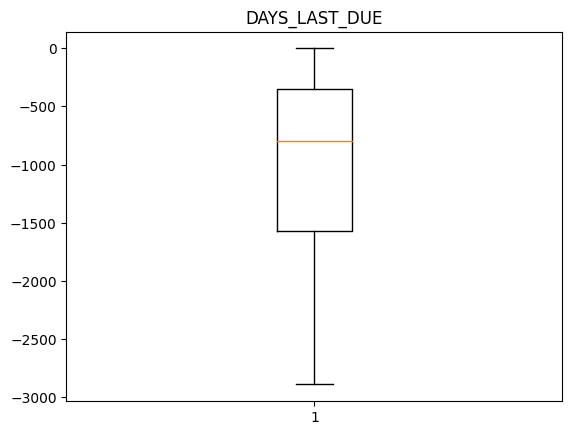

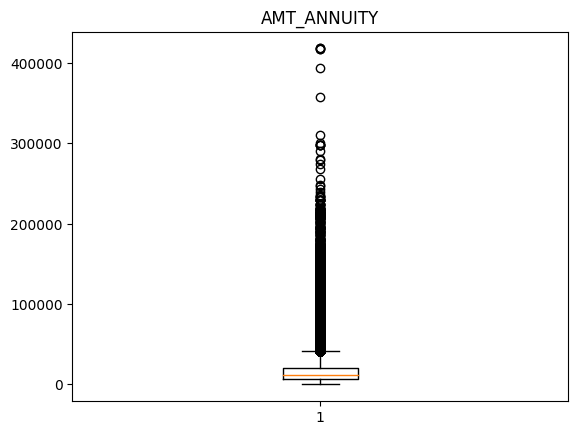

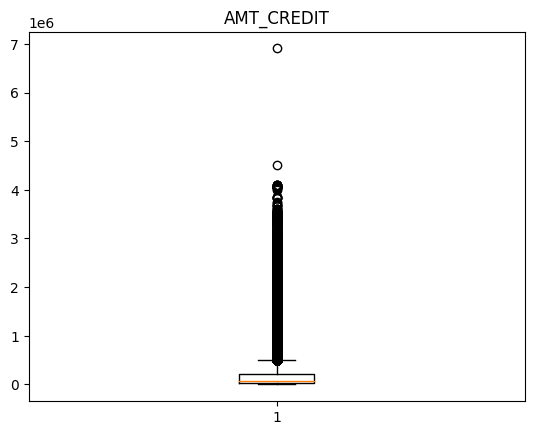

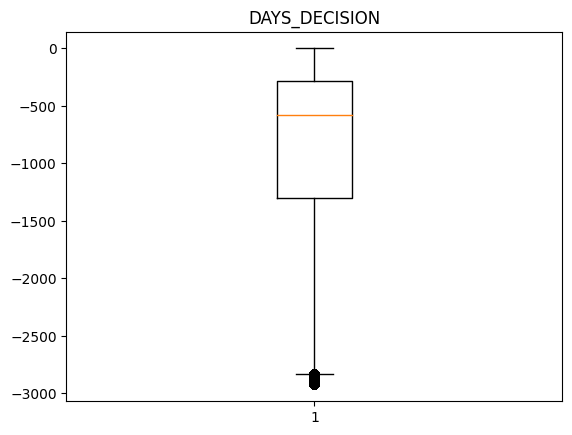

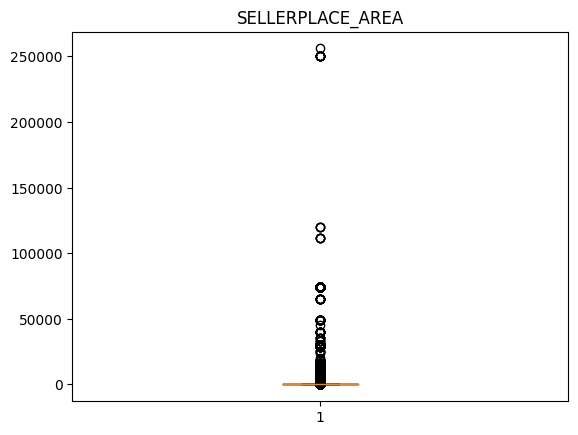

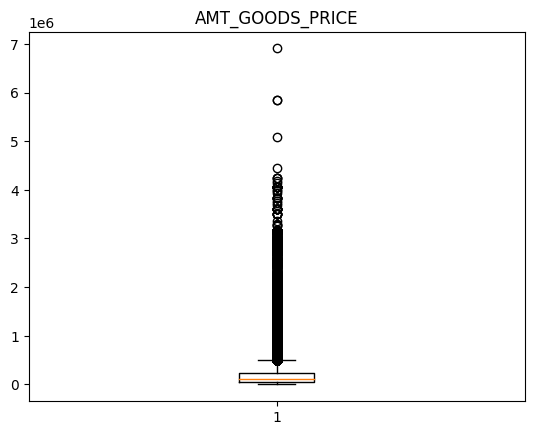

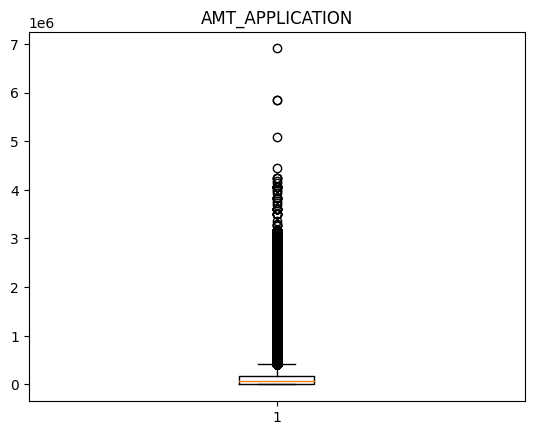

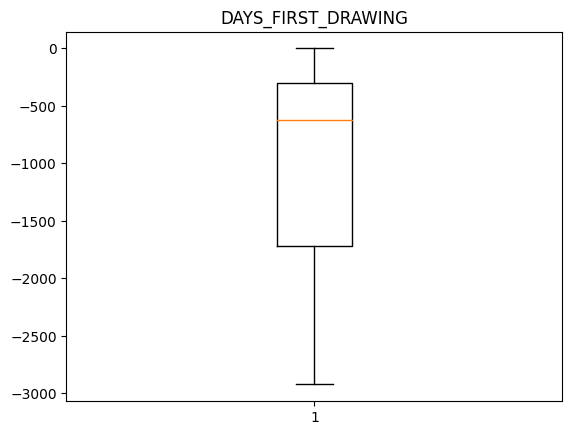

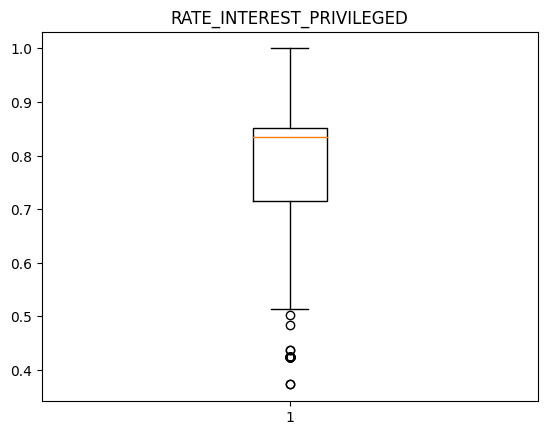

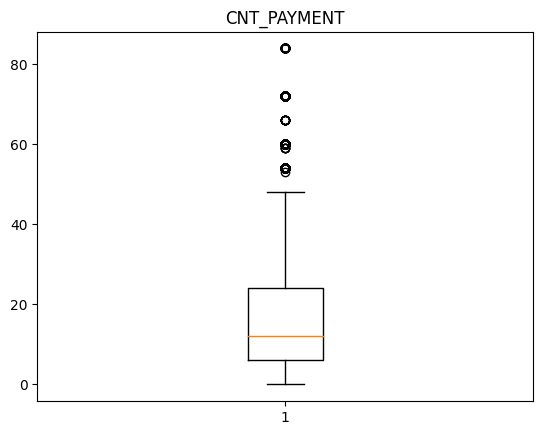

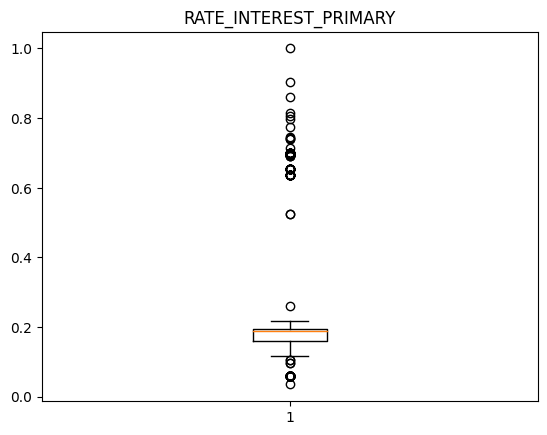

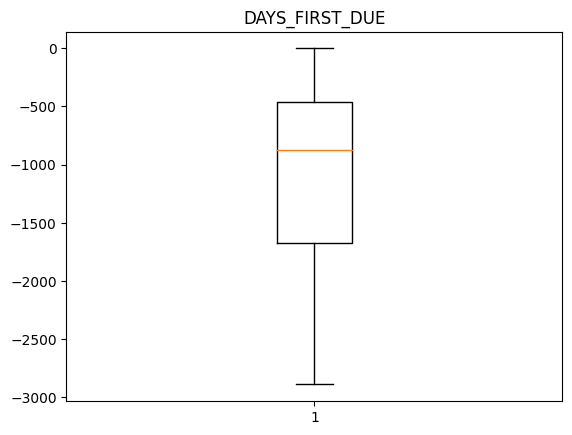

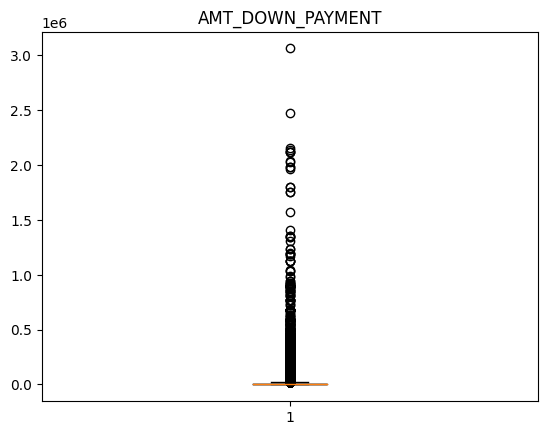

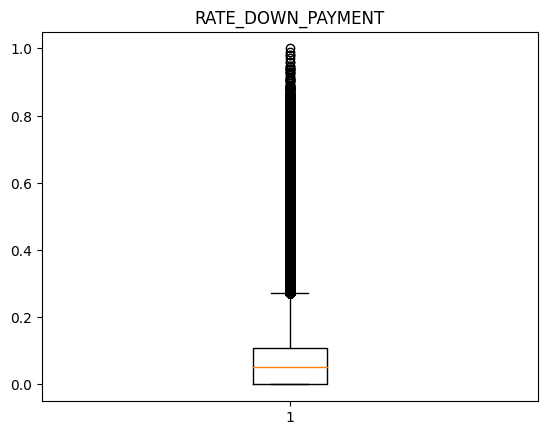

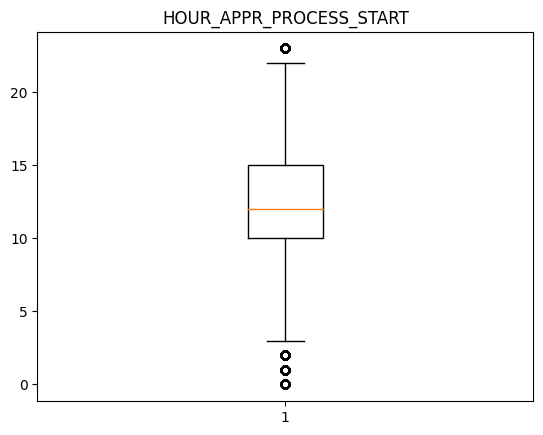

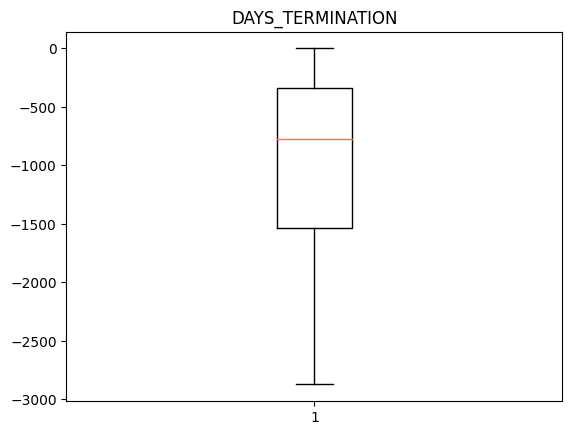

In [534]:
for num_col in pre_num:
    plt.boxplot(pre_app_encoded[num_col].dropna())     #无明显离散表示处理成功
    plt.title(num_col)
    plt.show()

处理完异常值后，因为previous application和主表格applicatoin是以SK_ID_CURR连接的，我们需要将一条SK_ID_CURR对应的记录加和处理为一条。

In [535]:
pre_app_encoded['SK_ID_PREV'].value_counts().values.max()

1

In [536]:
pre_app_encoded['SK_ID_CURR'].value_counts().values.max()

77

可见，我们有多条SK_ID_CURR对应单个SK_ID_PREV记录，接下来进行记录折叠。

In [537]:
pre_app_encoded

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NFLAG_LAST_APPL_IN_DAY_0,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_INSURED_ON_APPROVAL_0.0,NFLAG_INSURED_ON_APPROVAL_1.0
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,0.000000,0.182832,...,False,False,True,False,False,False,False,True,True,False
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,11,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,7,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,0.0,267295.5,12,0.000000,NaN,...,True,False,False,False,False,False,False,True,True,False
1670210,2357031,334635,6622.020,87750.0,64291.5,29250.0,87750.0,15,0.340554,NaN,...,True,False,False,False,False,False,False,True,True,False
1670211,2659632,249544,11520.855,105237.0,102523.5,10525.5,105237.0,12,0.101401,NaN,...,False,False,False,False,False,False,False,True,True,False
1670212,2785582,400317,18821.520,180000.0,191880.0,NaN,180000.0,9,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True


In [538]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [539]:
type_aggre(pre_app_encoded)

{'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_LAST_DUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_ANNUITY': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_DECISION': ['min', 'max', 'mean', 'sum', 'var'],
 'SELLERPLACE_AREA': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_APPLICATION': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', 'sum', 'var'],
 'CNT_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_FIRST_DUE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum', 'var'],
 'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_TERMINATION': ['min', 'max', 'mean', 'sum',

In [540]:
aggregations = type_aggre(pre_app_encoded)

pre_app_encoded_agg = pre_app_encoded.drop(['SK_ID_PREV'], axis=1).groupby('SK_ID_CURR').agg(aggregations)
pre_app_encoded_agg

DAYS_LAST_DUE_1ST_VERSION                                
                                 min     max         mean     sum   
SK_ID_CURR                                                          
100001                       -1499.0 -1499.0 -1499.000000 -1499.0  \
100002                         125.0   125.0   125.000000   125.0   
100003                       -1980.0  -386.0 -1004.333333 -3013.0   
100004                        -694.0  -694.0  -694.000000  -694.0   
100005                        -376.0  -376.0  -376.000000  -376.0   
...                              ...     ...          ...     ...   
456251                           0.0     0.0     0.000000     0.0   
456252                       -2316.0 -2316.0 -2316.000000 -2316.0   
456253                       -2722.0 -1716.0 -2219.000000 -4438.0   
456254                          99.0   203.0   151.000000   302.0   
456255                        -630.0   294.0  -108.333333  -650.0   

                          DAYS_LAST_DUE                                
                      var           min     max         mean     sum   
SK_ID_CURR                                                             
100001                NaN       -1619.0 -1619.0 -1619.000000 -1619.0  \
100002                NaN         -25.0   -25.0   -25.000000   -25.0   
100003      730974.333333       -1980.0  -536.0 -1054.333333 -3163.0   
100004                NaN        -724.0  -724.0  -724.000000  -724.0   
100005                NaN        -466.0  -466.0  -466.000000  -466.0   
...                   ...           ...     ...          ...     ...   
456251                NaN         -30.0   -30.0   -30.000000   -30.0   
456252                NaN       -2316.0 -2316.0 -2316.000000 -2316.0   
456253      506018.000000       -2722.0 -1716.0 -2219.000000 -4438.0   
456254        5408.000000           NaN     NaN          NaN     0.0   
456255      105934.666667        -690.0   -66.0  -358.333333 -2150.0   

                           ... PRODUCT_COMBINATION_POS industry with interest   
                      var  ...                                           mean   
SK_ID_CURR                 ...                                                  
100001                NaN  ...                                       0.000000  \
100002                NaN  ...                                       0.000000   
100003      645724.333333  ...                                       0.333333   
100004                NaN  ...                                       0.000000   
100005                NaN  ...                                       0.000000   
...                   ...  ...                                            ...   
456251                NaN  ...                                       0.000000   
456252                NaN  ...                                       0.000000   
456253      506018.000000  ...                                       0.000000   
456254                NaN  ...                                       0.000000   
456255       55970.666667  ...                                       0.125000   

           PRODUCT_COMBINATION_POS industry without interest   
                                                        mean   
SK_ID_CURR                                                     
100001                                                   0.0  \
100002                                                   0.0   
100003                                                   0.0   
100004                                                   0.0   
100005                                                   0.0   
...                                                      ...   
456251                                                   0.0   
456252                                                   0.0   
456253                                                   0.0   
456254                                                   0.0   
456255                                                   0.0   

   

### 数据集2. bureau

In [541]:
bureau = pd.read_csv('bureau.csv')
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [542]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [543]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [544]:
num_cols, cat_cols = get_cols(bureau)
num_cols

['CREDIT_DAY_OVERDUE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM_DEBT',
 'DAYS_CREDIT_ENDDATE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_BUREAU',
 'AMT_ANNUITY',
 'DAYS_CREDIT',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_MAX_OVERDUE',
 'DAYS_CREDIT_UPDATE']

In [545]:
cat_cols

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

将类型类变量用One-Hot转化为数值类变量。

In [546]:
bureau_encoded = bureau.copy()          #创建一个副本以保留原始数据

for col in cat_cols:
    one_hot_encoded = pd.get_dummies(bureau[col], prefix=col)
    bureau_encoded = pd.concat([bureau_encoded, one_hot_encoded], axis=1)
    bureau_encoded.drop(col, axis=1, inplace=True)

bureau_encoded

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,...,False,False,False,False,False,False,False,False,False,False
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,...,False,False,False,False,False,False,False,False,False,False
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,...,False,False,False,False,False,False,False,False,False,False
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,NaN,...,False,False,False,False,False,False,False,False,False,False
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,...,False,False,False,False,False,True,False,False,False,False
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,...,False,False,False,False,False,False,False,False,False,False
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,...,False,False,False,False,False,False,False,False,False,False
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,...,False,False,False,False,False,False,False,False,False,False


寻找/处理数值类异常值。

In [547]:
for col in num_cols:
    print('-------------------')
    print(col)
    print(bureau_encoded[col].describe())

-------------------
CREDIT_DAY_OVERDUE
count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64
-------------------
DAYS_ENDDATE_FACT
count    1.082775e+06
mean    -1.017437e+03
std      7.140106e+02
min     -4.202300e+04
25%     -1.489000e+03
50%     -8.970000e+02
75%     -4.250000e+02
max      0.000000e+00
Name: DAYS_ENDDATE_FACT, dtype: float64
-------------------
AMT_CREDIT_SUM_DEBT
count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64
-------------------
DAYS_CREDIT_ENDDATE
count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDI

观察这些不同变量的统计数值，似乎AMT_CREDIT_SUM_DEBT（复数最小值）、AMT_CREDIT_SUM_LIMIT（复数最小值）较为异常。

首先，处理AMT_CREDIT_SUM_DEBT、AMT_CREDIT_SUM_LIMIT的异常负值问题（最小值为负）。

先不做任何处理，我们来看看这样的个例有多少个来决定这种记录是否为异常。

In [548]:
abnormal = ['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT']

for potent in abnormal:
    rows = bureau_encoded[bureau_encoded[potent] < 0][potent]
    print('-----------------')
    print(potent)
    print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 8418
-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 351


In [549]:
for col in abnormal:
    print('-------------------')
    print(col)
    print(bureau_encoded[col].describe())

-------------------
AMT_CREDIT_SUM_DEBT
count    1.458759e+06
mean     1.370851e+05
std      6.774011e+05
min     -4.705600e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.015350e+04
max      1.701000e+08
Name: AMT_CREDIT_SUM_DEBT, dtype: float64
-------------------
AMT_CREDIT_SUM_LIMIT
count    1.124648e+06
mean     6.229515e+03
std      4.503203e+04
min     -5.864061e+05
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.705600e+06
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64


此处，AMT_CREDIT_SUM_DEBT（Current debt on Credit Bureau credit-目前在信用局信用的债务），AMT_CREDIT_SUM_LIMIT（Current credit limit of credit card reported in Credit Bureau-在信用局报告的信用卡当前的信用额度）各自表示目前在信用局信用的债务和在信用局报告的信用卡当前的信用额度，而这两种变量均可以为负值，故此处不做异常记录处理。

进一步观察这两个变量的异常值的分布情况，去掉例外值。

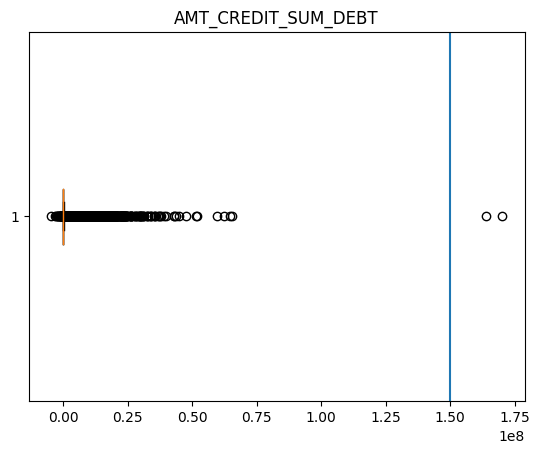

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 2


In [550]:
col = 'AMT_CREDIT_SUM_DEBT'

plt.boxplot(bureau_encoded[col].dropna(), vert=False)   
place = 150000000
plt.axvline(x=place)    # 在箱线图中标出位置

plt.title(col)
plt.show()



potent = 'AMT_CREDIT_SUM_DEBT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

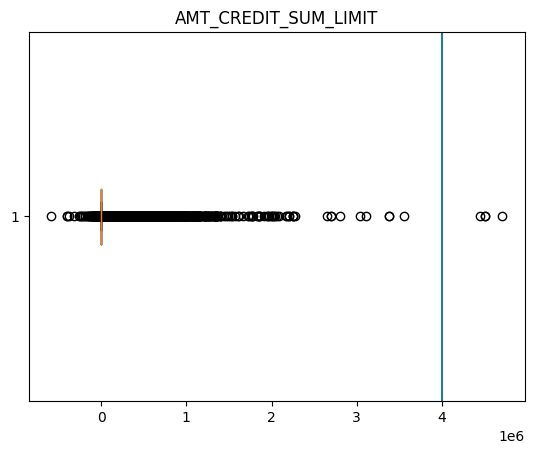

-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 4


In [551]:
col = 'AMT_CREDIT_SUM_LIMIT'

plt.boxplot(bureau_encoded[col].dropna(), vert=False)   
place = 4000000
plt.axvline(x=place)    # 在箱线图中标出位置

plt.title(col)
plt.show()



potent = 'AMT_CREDIT_SUM_LIMIT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

示例不足（2/4例），化为NaN。

In [552]:
potent = 'AMT_CREDIT_SUM_DEBT'
place = 150000000

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

In [553]:
#检查
potent = 'AMT_CREDIT_SUM_DEBT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_DEBT
# of cases = 0


In [554]:
potent = 'AMT_CREDIT_SUM_LIMIT'
place = 4000000

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

In [555]:
#检查
potent = 'AMT_CREDIT_SUM_LIMIT'

rows = bureau_encoded[bureau_encoded[potent] > place][potent]     #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_SUM_LIMIT
# of cases = 0


再查。

In [556]:
num_cols

['CREDIT_DAY_OVERDUE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM_DEBT',
 'DAYS_CREDIT_ENDDATE',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_BUREAU',
 'AMT_ANNUITY',
 'DAYS_CREDIT',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_MAX_OVERDUE',
 'DAYS_CREDIT_UPDATE']

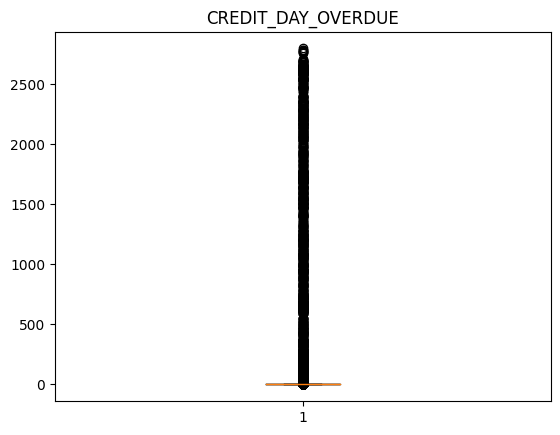

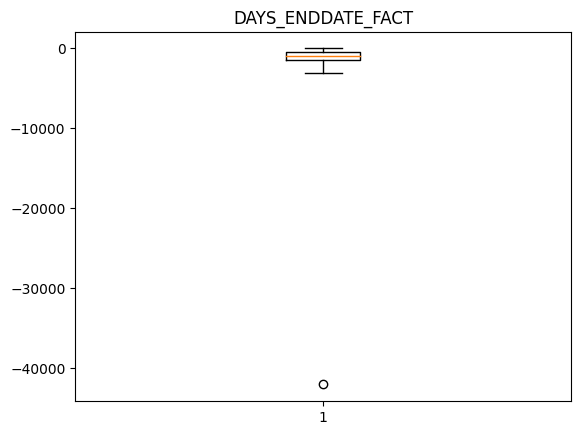

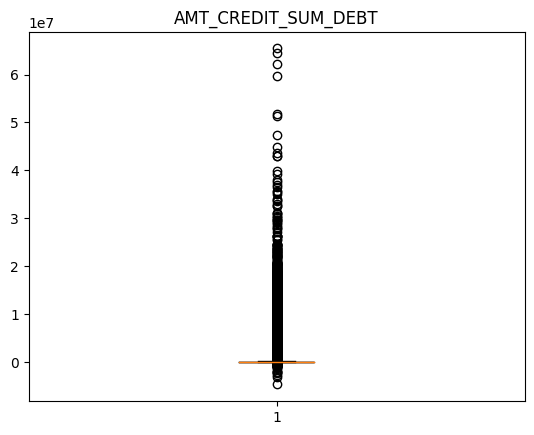

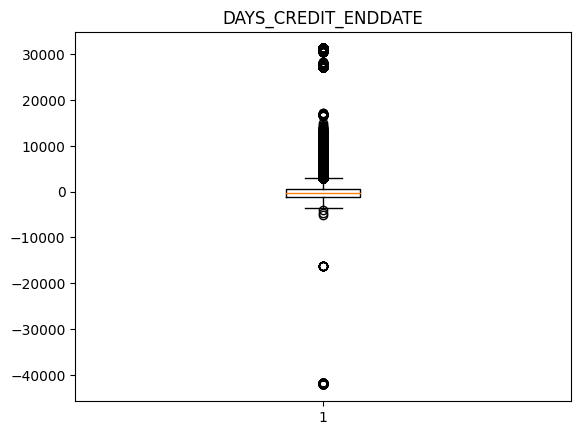

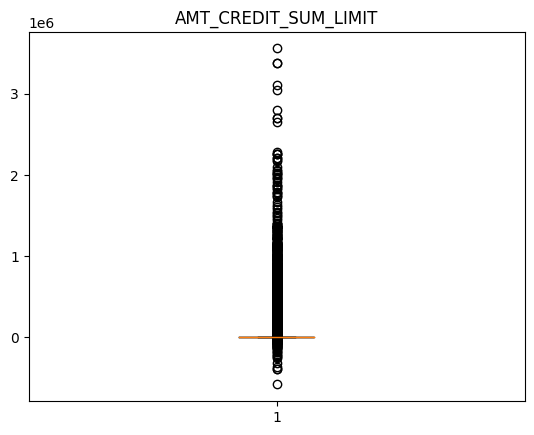

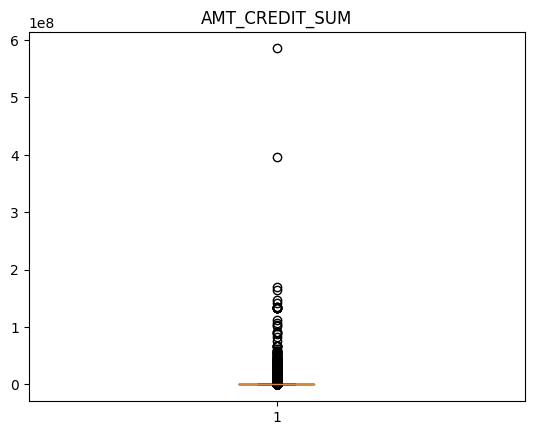

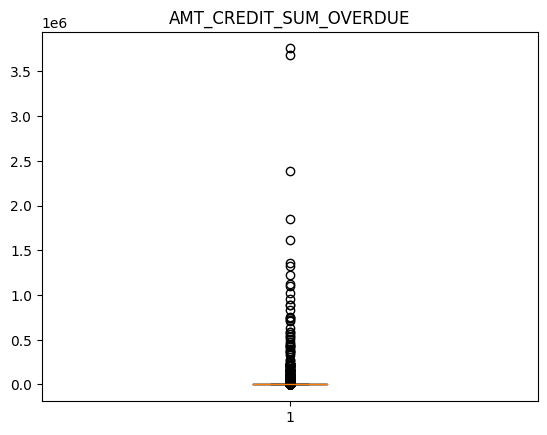

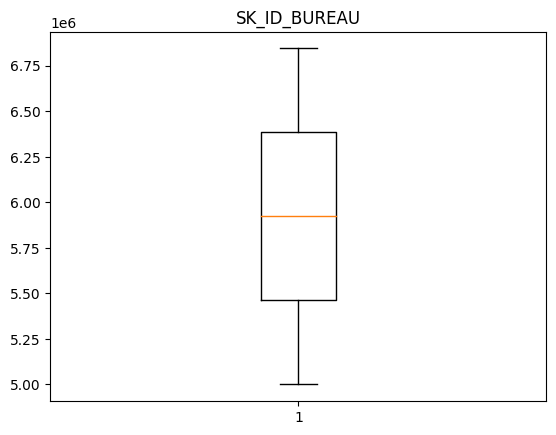

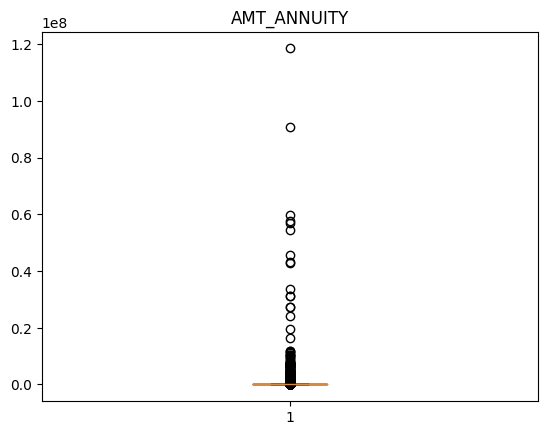

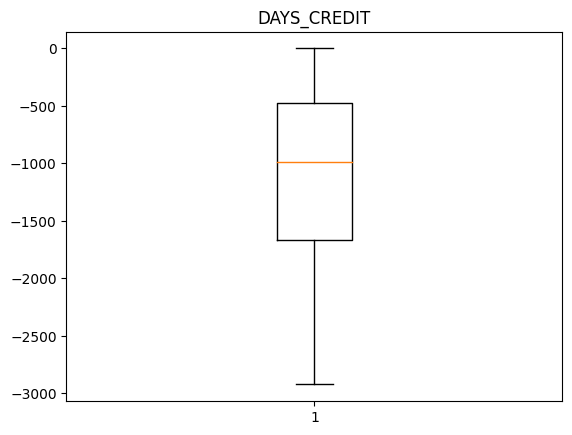

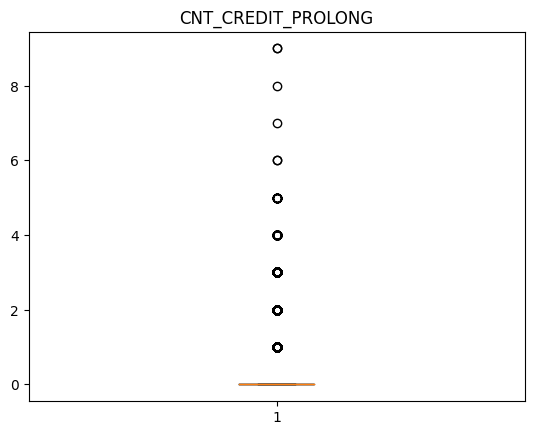

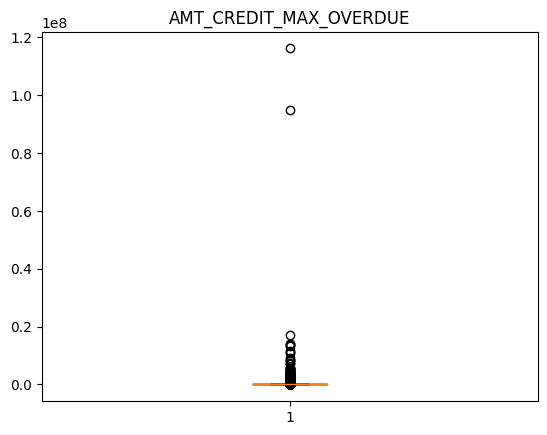

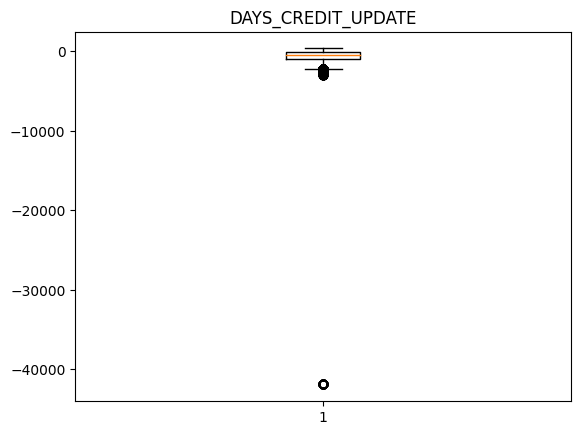

In [557]:
for col in num_cols:
    plt.boxplot(bureau_encoded[col].dropna())     #观察drop后数值是否正常了，无明显离散表示处理成功
    plt.title(col)
    plt.show()

复查DAYS_CREDIT_ENDDATE、DAYS_ENDDATE_FACT、AMT_CREDIT_MAX_OVERDUE、DAYS_CREDIT_UPDATE。

In [558]:
abnormal = ['DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','DAYS_CREDIT_UPDATE']

In [559]:
potent = 'DAYS_CREDIT_ENDDATE'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_CREDIT_ENDDATE
# of cases = 134


In [560]:
potent = 'DAYS_ENDDATE_FACT'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_ENDDATE_FACT
# of cases = 1


In [561]:
potent = 'AMT_CREDIT_MAX_OVERDUE'
place = 0.8*10**8

rows = bureau_encoded[bureau_encoded[potent] > place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
AMT_CREDIT_MAX_OVERDUE
# of cases = 2


In [562]:
potent = 'DAYS_CREDIT_UPDATE'
place = -30000

rows = bureau_encoded[bureau_encoded[potent] < place][potent]    #有多少例外值的记录
print('-----------------')
print(potent)
print('# of cases =', len(rows))

-----------------
DAYS_CREDIT_UPDATE
# of cases = 95


DAYS_ENDDATE_FACT和AMT_CREDIT_MAX_OVERDUE示例过少，化为NaN。

In [563]:
potent = 'DAYS_ENDDATE_FACT'
place = -30000

bureau_encoded.loc[bureau_encoded[potent] < place, potent] = np.nan   #略去异常值的记录

In [564]:
potent = 'AMT_CREDIT_MAX_OVERDUE'
place = 0.8*10**8

bureau_encoded.loc[bureau_encoded[potent] > place, potent] = np.nan   #略去异常值的记录

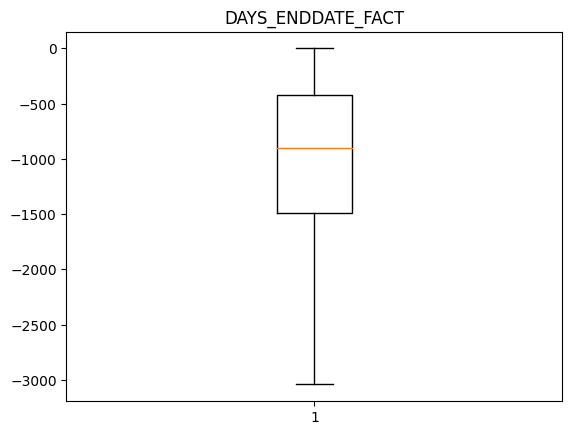

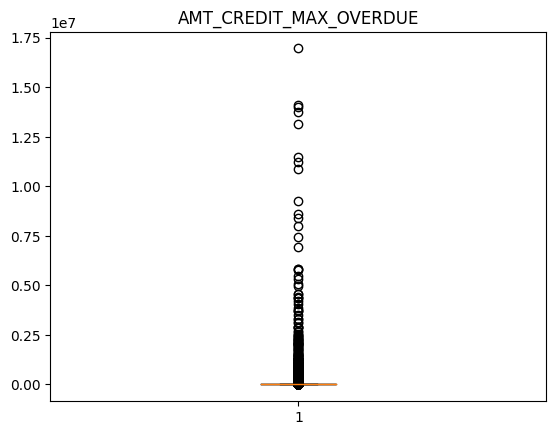

In [565]:
for col in ['DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE']:
    plt.boxplot(bureau_encoded[col].dropna())     #观察drop后数值是否正常了，无明显离散表示处理成功
    plt.title(col)
    plt.show()

存在SK_ID_BUREAU的重合，进行aggregation以便于后前合并。

In [566]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [567]:
type_aggre(bureau_encoded)

{'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_ENDDATE_FACT': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_LIMIT': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_SUM_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'SK_ID_BUREAU': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_ANNUITY': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT': ['min', 'max', 'mean', 'sum', 'var'],
 'CNT_CREDIT_PROLONG': ['min', 'max', 'mean', 'sum', 'var'],
 'AMT_CREDIT_MAX_OVERDUE': ['min', 'max', 'mean', 'sum', 'var'],
 'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean', 'sum', 'var'],
 'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Bad debt': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_CURRENCY_currency 1': ['mean'],
 'CREDIT_CURRENCY_currency 2': ['mean']

In [568]:
aggregations = type_aggre(bureau_encoded)

bureau_encoded_agg = bureau_encoded.groupby('SK_ID_CURR').agg(aggregations)
bureau_encoded_agg

CREDIT_DAY_OVERDUE                   DAYS_ENDDATE_FACT          
                          min max mean sum  var               min    max   
SK_ID_CURR                                                                 
100001                      0   0  0.0   0  0.0           -1328.0 -544.0  \
100002                      0   0  0.0   0  0.0           -1185.0  -36.0   
100003                      0   0  0.0   0  0.0           -2131.0 -540.0   
100004                      0   0  0.0   0  0.0            -683.0 -382.0   
100005                      0   0  0.0   0  0.0            -123.0 -123.0   
...                       ...  ..  ...  ..  ...               ...    ...   
456249                      0   0  0.0   0  0.0           -2525.0 -291.0   
456250                      0   0  0.0   0  0.0            -760.0 -760.0   
456253                      0   0  0.0   0  0.0            -794.0 -794.0   
456254                      0   0  0.0   0  NaN            -859.0 -859.0   
456255                      0   0  0.0   0  0.0           -1621.0 -712.0   

                                                 ...   
                   mean      sum            var  ...   
SK_ID_CURR                                       ...   
100001      -825.500000  -3302.0  136219.000000  ...  \
100002      -697.500000  -4185.0  266248.300000  ...   
100003     -1097.333333  -3292.0  802990.333333  ...   
100004      -532.500000  -1065.0   45300.500000  ...   
100005      -123.000000   -123.0            NaN  ...   
...                 ...      ...            ...  ...   
456249     -1364.750000 -16377.0  403046.386364  ...   
456250      -760.000000   -760.0            NaN  ...   
456253      -794.000000  -1588.0       0.000000  ...   
456254      -859.000000   -859.0            NaN  ...   
456255      -968.333333  -5810.0  112563.066667  ...   

           CREDIT_TYPE_Interbank credit   
                                   mean   
SK_ID_CURR                                
100001                              0.0  \
100002                              0.0   
100003                              0.0   
100004                              0.0   
100005                              0.0   
...                                 ...   
456249                              0.0   
456250                              0.0   
456253                              0.0   
456254                              0.0   
456255                              0.0   

           CREDIT_TYPE_Loan for business development   
                                                mean   
SK_ID_CURR                                             
100001                                           0.0  \
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   
...                                              ...   
456249                                           0.0   
456250                                           0.0   
456253                                           0.0   
456254                                           0.0   
456255                                           0.0   

           CREDIT_TYPE_Loan for purchase of shares (margin lending)   
                                                               mean   
SK_ID_CURR                                                            
100001                                                    0.0        \
100002                                                    0.0         
100003                                                    0.0         
100004                                                    0.0         
100005                                                    0.0         
...                                                       ...         
456249                                                    0.0         
456250                                                    0.0  

### 数据集3. application

In [569]:
app = pd.read_csv('application_train.csv')
app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


初步了解数据集变量。

In [570]:
app.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [571]:
def num_col_checker(df):     #从非object类变量里挑出类型类变量
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    count_num = len(num_cols)

    picked = []

    for col in num_cols:
        if len(df[col].value_counts()) <= 5:
            picked.append(col)

    return picked



def get_cols(df):       #给数据集的变量分类
    if 'SK_ID_PREV' in df.columns:
        df = df.drop(['SK_ID_PREV'],axis=1)
    if 'SK_ID_CURR' in df.columns:
        df = df.drop(['SK_ID_CURR'],axis=1)
    num_cols = list(df.select_dtypes(include=['int', 'float']))
    num_cols = list(set(num_cols) - set(num_col_checker(df)))    #减去隐藏的类型类变量
 
    cat_cols = list(df.select_dtypes(include=['O', 'bool']))
    cat_cols = cat_cols + num_col_checker(df)    #把藏在数值类变量里的类型变量加上

    return num_cols, cat_cols

    

def type_aggre(df):
    aggre_dict = {}
    vals = []

    num_cols, cat_cols = get_cols(df)
    count_num = len(num_cols)
    count_cat = len(cat_cols)

    cols = num_cols + cat_cols
    
    
    if len(cat_cols) >= 1:   #存在类型类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])
        for i in range(count_cat):
            vals.append(['mean'])

        pairs = list(zip(cols, vals))   #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}

        
    else:        #只有数值类变量
        for i in range(count_num):
            vals.append(['min', 'max', 'mean', 'sum', 'var'])

        pairs = list(zip(cols, vals))    #合并成对应处理方法
        aggre_dict = {k: v for k, v in pairs}
        

    return aggre_dict

In [572]:
num_cols, cat_cols = get_cols(app)
num_cols

['YEARS_BUILD_AVG',
 'COMMONAREA_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLOORSMAX_MODE',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MEDI',
 'AMT_CREDIT',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'DAYS_REGISTRATION',
 'ENTRANCES_MODE',
 'LIVINGAREA_MODE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_CHILDREN',
 'OWN_CAR_AGE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'APARTMENTS_MODE',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'LIVINGAPARTMENTS_MEDI',
 'EXT_SOURCE_2',
 'NONLIVINGAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'APARTMENTS_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DAYS_EMPLOYED',
 'ELEVATORS_MODE',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'BASEMENTAREA_AVG',
 'FLOORSMIN_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'HOUR_APPR_PROCESS_START',
 'YEARS_BUILD_MEDI',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'APAR

In [573]:
cat_cols.remove('TARGET')   #单独拎出被预测值TARGET，不做One-Hot处理
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_

将 类型变量 用One-Hot 转为 离散的 数值类变量。

In [574]:
app_encoded = app.copy()  #创建一个副本以保留原始数据

for col in cat_cols:
    one_hot_encoded = pd.get_dummies(app[col], prefix=col)
    app_encoded = pd.concat([app_encoded, one_hot_encoded], axis=1)
    app_encoded.drop(col, axis=1, inplace=True)

app_encoded

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,False,True,False,True,False,True,False,False,False,False


寻找/处理数值类异常值。

In [575]:
for num_col in num_cols:
    print('-------------------')
    print(num_col)
    print(app_encoded[num_col].describe())

-------------------
YEARS_BUILD_AVG
count    103023.000000
mean          0.752471
std           0.113280
min           0.000000
25%           0.687200
50%           0.755200
75%           0.823200
max           1.000000
Name: YEARS_BUILD_AVG, dtype: float64
-------------------
COMMONAREA_MEDI
count    92646.000000
mean         0.044595
std          0.076144
min          0.000000
25%          0.007900
50%          0.020800
75%          0.051300
max          1.000000
Name: COMMONAREA_MEDI, dtype: float64
-------------------
DEF_30_CNT_SOCIAL_CIRCLE
count    306490.000000
mean          0.143421
std           0.446698
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64
-------------------
FLOORSMAX_MODE
count    154491.000000
mean          0.222315
std           0.143709
min           0.000000
25%           0.166700
50%           0.166700
75%           0.333300
max           1.0000

似乎许多列根本没有数据，去掉这些列。

In [576]:
app_encoded_dropped = app_encoded.copy()
num_col_dropped = num_cols.copy()
count = 0

for num_col in num_cols:
    if sum(app_encoded_dropped[num_col] == 0):
        print('-------------------')
        app_encoded_dropped = app_encoded_dropped.drop([num_col], axis=1)
        num_col_dropped.remove(num_col)
        print(num_col, 'dropped')
        count +=1 

count

-------------------
YEARS_BUILD_AVG dropped
-------------------
COMMONAREA_MEDI dropped
-------------------
DEF_30_CNT_SOCIAL_CIRCLE dropped
-------------------
FLOORSMAX_MODE dropped
-------------------
LIVINGAPARTMENTS_AVG dropped
-------------------
NONLIVINGAPARTMENTS_MODE dropped
-------------------
NONLIVINGAREA_MEDI dropped
-------------------
AMT_REQ_CREDIT_BUREAU_MON dropped
-------------------
DAYS_REGISTRATION dropped
-------------------
ENTRANCES_MODE dropped
-------------------
LIVINGAREA_MODE dropped
-------------------
AMT_REQ_CREDIT_BUREAU_QRT dropped
-------------------
CNT_CHILDREN dropped
-------------------
OWN_CAR_AGE dropped
-------------------
COMMONAREA_MODE dropped
-------------------
FLOORSMIN_MODE dropped
-------------------
LIVINGAREA_AVG dropped
-------------------
NONLIVINGAREA_AVG dropped
-------------------
NONLIVINGAPARTMENTS_AVG dropped
-------------------
APARTMENTS_MODE dropped
-------------------
AMT_REQ_CREDIT_BUREAU_WEEK dropped
------------------

59

In [577]:
app_encoded_dropped

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,1.0,0.083037,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,2.0,0.311267,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,2.0,NaN,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,1.0,0.145570,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,1.0,NaN,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,1.0,0.744026,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,2.0,NaN,...,False,True,False,True,False,True,False,False,False,False


In [578]:
len(list(set(num_cols) - set(num_col_dropped)))     #去掉了的列的总数

59

继续处理。

In [579]:
for num_col in num_col_dropped:
    print('-------------------')
    print(num_col)
    print(app_encoded_dropped[num_col].describe())

-------------------
AMT_CREDIT
count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
-------------------
EXT_SOURCE_2
count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.170000e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64
-------------------
REGION_POPULATION_RELATIVE
count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64
-------------------
AMT_ANNUITY
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, d

再检查。

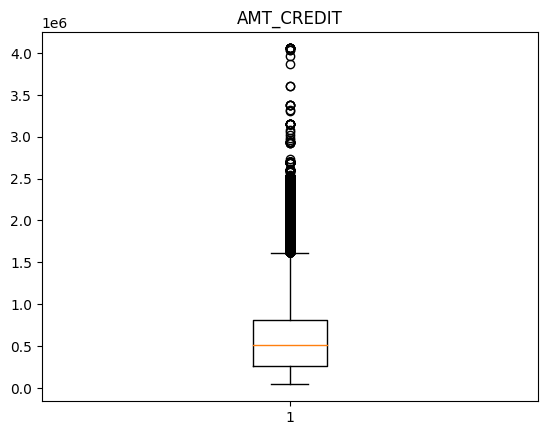

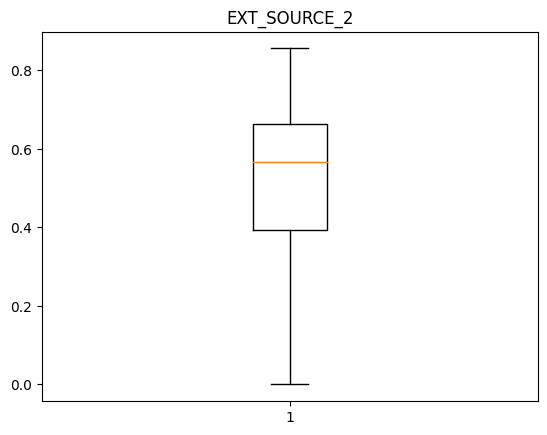

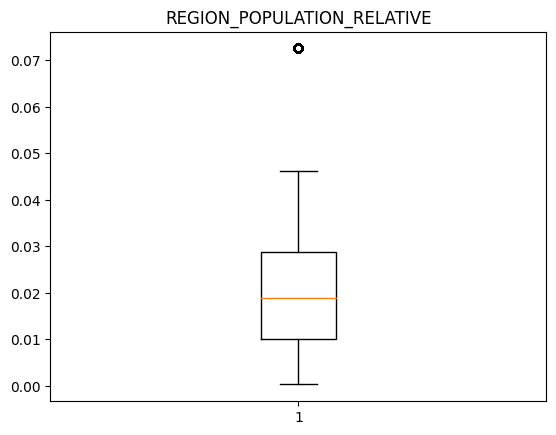

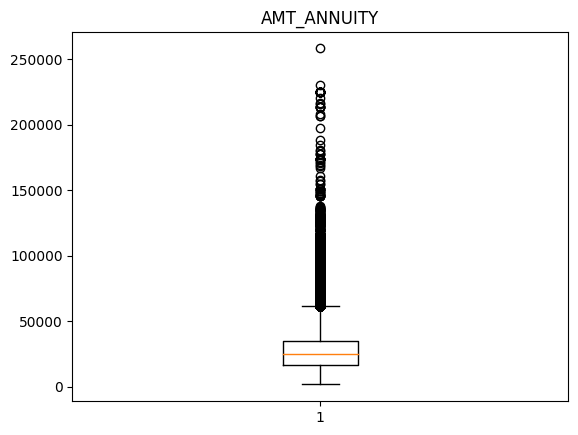

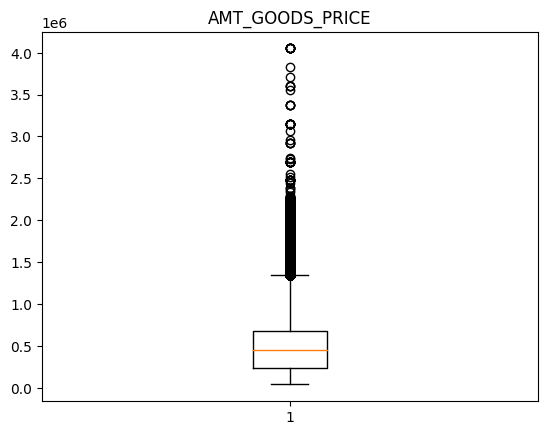

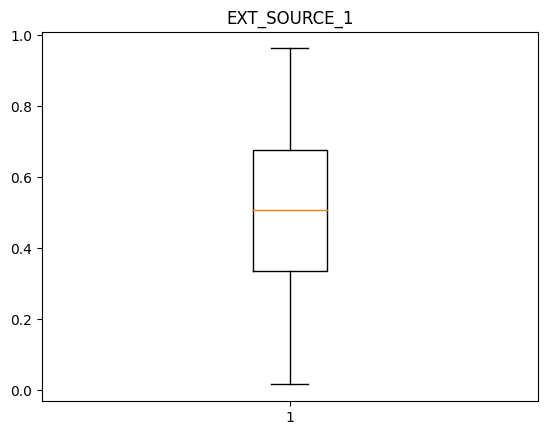

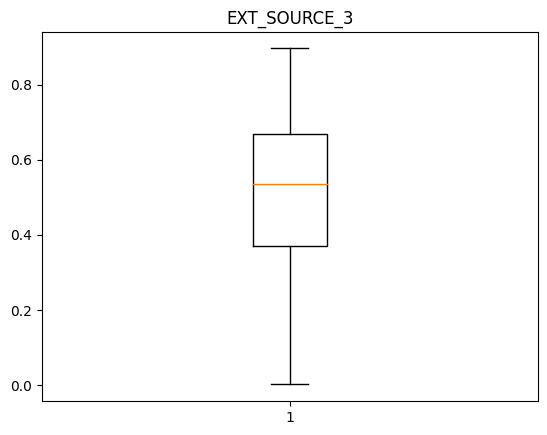

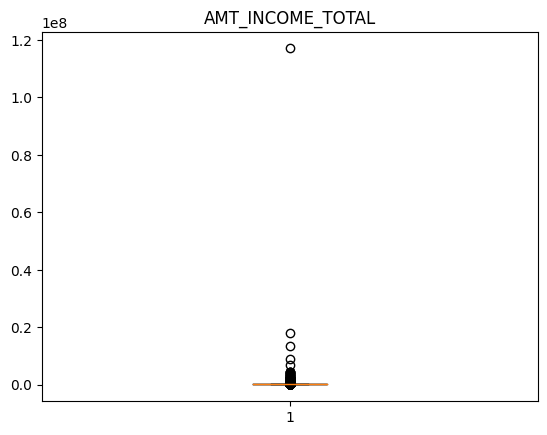

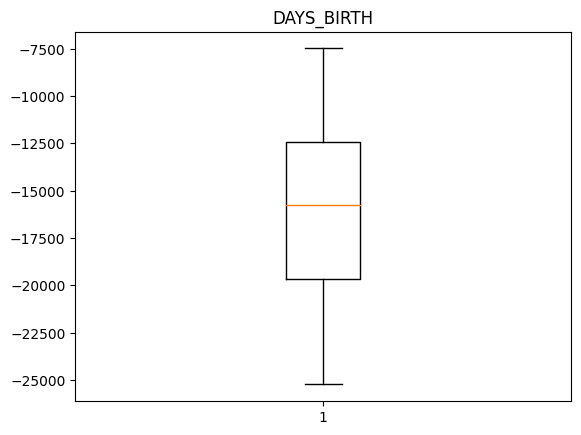

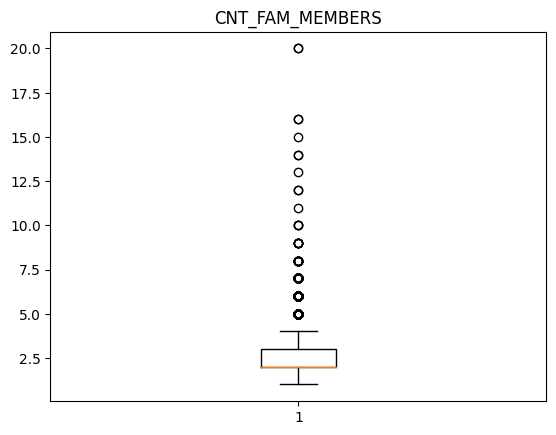

In [580]:
for num_col in num_col_dropped:
    plt.boxplot(app_encoded_dropped[num_col].dropna())
    plt.title(num_col)
    plt.show()

似乎AMT_INCOME_TOTAL和REGION_POPULATION_RELATIVE有游离的最大值。

In [581]:
app_encoded_dropped['REGION_POPULATION_RELATIVE'].sort_values(ascending=False)

223701    0.072508
294650    0.072508
10496     0.072508
294671    0.072508
10500     0.072508
            ...   
78542     0.000533
195339    0.000533
257223    0.000533
280258    0.000290
248609    0.000290
Name: REGION_POPULATION_RELATIVE, Length: 307511, dtype: float64

In [582]:
app_encoded_dropped['AMT_INCOME_TOTAL'].sort_values(ascending=False)

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
             ...     
240137        26100.0
186643        26100.0
246104        26100.0
20727         25650.0
1678          25650.0
Name: AMT_INCOME_TOTAL, Length: 307511, dtype: float64

均似乎其有许多个例，不做处理。

此处，application无重复的ID记录，不做aggregation处理。

-------------

### 合并数据集

In [583]:
pre_app_encoded_agg

DAYS_LAST_DUE_1ST_VERSION                                
                                 min     max         mean     sum   
SK_ID_CURR                                                          
100001                       -1499.0 -1499.0 -1499.000000 -1499.0  \
100002                         125.0   125.0   125.000000   125.0   
100003                       -1980.0  -386.0 -1004.333333 -3013.0   
100004                        -694.0  -694.0  -694.000000  -694.0   
100005                        -376.0  -376.0  -376.000000  -376.0   
...                              ...     ...          ...     ...   
456251                           0.0     0.0     0.000000     0.0   
456252                       -2316.0 -2316.0 -2316.000000 -2316.0   
456253                       -2722.0 -1716.0 -2219.000000 -4438.0   
456254                          99.0   203.0   151.000000   302.0   
456255                        -630.0   294.0  -108.333333  -650.0   

                          DAYS_LAST_DUE                                
                      var           min     max         mean     sum   
SK_ID_CURR                                                             
100001                NaN       -1619.0 -1619.0 -1619.000000 -1619.0  \
100002                NaN         -25.0   -25.0   -25.000000   -25.0   
100003      730974.333333       -1980.0  -536.0 -1054.333333 -3163.0   
100004                NaN        -724.0  -724.0  -724.000000  -724.0   
100005                NaN        -466.0  -466.0  -466.000000  -466.0   
...                   ...           ...     ...          ...     ...   
456251                NaN         -30.0   -30.0   -30.000000   -30.0   
456252                NaN       -2316.0 -2316.0 -2316.000000 -2316.0   
456253      506018.000000       -2722.0 -1716.0 -2219.000000 -4438.0   
456254        5408.000000           NaN     NaN          NaN     0.0   
456255      105934.666667        -690.0   -66.0  -358.333333 -2150.0   

                           ... PRODUCT_COMBINATION_POS industry with interest   
                      var  ...                                           mean   
SK_ID_CURR                 ...                                                  
100001                NaN  ...                                       0.000000  \
100002                NaN  ...                                       0.000000   
100003      645724.333333  ...                                       0.333333   
100004                NaN  ...                                       0.000000   
100005                NaN  ...                                       0.000000   
...                   ...  ...                                            ...   
456251                NaN  ...                                       0.000000   
456252                NaN  ...                                       0.000000   
456253      506018.000000  ...                                       0.000000   
456254                NaN  ...                                       0.000000   
456255       55970.666667  ...                                       0.125000   

           PRODUCT_COMBINATION_POS industry without interest   
                                                        mean   
SK_ID_CURR                                                     
100001                                                   0.0  \
100002                                                   0.0   
100003                                                   0.0   
100004                                                   0.0   
100005                                                   0.0   
...                                                      ...   
456251                                                   0.0   
456252                                                   0.0   
456253                                                   0.0   
456254                                                   0.0   
456255                                                   0.0   

   

In [584]:
pre_app_encoded_agg.columns = pre_app_encoded_agg.columns.to_flat_index()
pre_app_encoded_agg

,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(DAYS_LAST_DUE, min)","(DAYS_LAST_DUE, max)","(DAYS_LAST_DUE, mean)","(DAYS_LAST_DUE, sum)","(DAYS_LAST_DUE, var)",...,"(PRODUCT_COMBINATION_POS industry with interest, mean)","(PRODUCT_COMBINATION_POS industry without interest, mean)","(PRODUCT_COMBINATION_POS mobile with interest, mean)","(PRODUCT_COMBINATION_POS mobile without interest, mean)","(PRODUCT_COMBINATION_POS other with interest, mean)","(PRODUCT_COMBINATION_POS others without interest, mean)","(NFLAG_LAST_APPL_IN_DAY_0, mean)","(NFLAG_LAST_APPL_IN_DAY_1, mean)","(NFLAG_INSURED_ON_APPROVAL_0.0, mean)","(NFLAG_INSURED_ON_APPROVAL_1.0, mean)"
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1499.0,-1499.0,-1499.000000,-1499.0,NaN,-1619.0,-1619.0,-1619.000000,-1619.0,NaN,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
100002,125.0,125.0,125.000000,125.0,NaN,-25.0,-25.0,-25.000000,-25.0,NaN,...,0.000000,0.0,0.00,0.0,1.0,0.0,0.0,1.0,1.000000,0.000000
100003,-1980.0,-386.0,-1004.333333,-3013.0,730974.333333,-1980.0,-536.0,-1054.333333,-3163.0,645724.333333,...,0.333333,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
100004,-694.0,-694.0,-694.000000,-694.0,NaN,-724.0,-724.0,-724.000000,-724.0,NaN,...,0.000000,0.0,0.00,1.0,0.0,0.0,0.0,1.0,1.000000,0.000000
100005,-376.0,-376.0,-376.000000,-376.0,NaN,-466.0,-466.0,-466.000000,-466.0,NaN,...,0.000000,0.0,0.50,0.0,0.0,0.0,0.0,1.0,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.000000,0.0,NaN,-30.0,-30.0,-30.000000,-30.0,NaN,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
456252,-2316.0,-2316.0,-2316.000000,-2316.0,NaN,-2316.0,-2316.0,-2316.000000,-2316.0,NaN,...,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000
456253,-2722.0,-1716.0,-2219.000000,-4438.0,506018.000000,-2722.0,-1716.0,-2219.000000,-4438.0,506018.000000,...,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000


In [585]:
bureau_encoded_agg

CREDIT_DAY_OVERDUE                   DAYS_ENDDATE_FACT          
                          min max mean sum  var               min    max   
SK_ID_CURR                                                                 
100001                      0   0  0.0   0  0.0           -1328.0 -544.0  \
100002                      0   0  0.0   0  0.0           -1185.0  -36.0   
100003                      0   0  0.0   0  0.0           -2131.0 -540.0   
100004                      0   0  0.0   0  0.0            -683.0 -382.0   
100005                      0   0  0.0   0  0.0            -123.0 -123.0   
...                       ...  ..  ...  ..  ...               ...    ...   
456249                      0   0  0.0   0  0.0           -2525.0 -291.0   
456250                      0   0  0.0   0  0.0            -760.0 -760.0   
456253                      0   0  0.0   0  0.0            -794.0 -794.0   
456254                      0   0  0.0   0  NaN            -859.0 -859.0   
456255                      0   0  0.0   0  0.0           -1621.0 -712.0   

                                                 ...   
                   mean      sum            var  ...   
SK_ID_CURR                                       ...   
100001      -825.500000  -3302.0  136219.000000  ...  \
100002      -697.500000  -4185.0  266248.300000  ...   
100003     -1097.333333  -3292.0  802990.333333  ...   
100004      -532.500000  -1065.0   45300.500000  ...   
100005      -123.000000   -123.0            NaN  ...   
...                 ...      ...            ...  ...   
456249     -1364.750000 -16377.0  403046.386364  ...   
456250      -760.000000   -760.0            NaN  ...   
456253      -794.000000  -1588.0       0.000000  ...   
456254      -859.000000   -859.0            NaN  ...   
456255      -968.333333  -5810.0  112563.066667  ...   

           CREDIT_TYPE_Interbank credit   
                                   mean   
SK_ID_CURR                                
100001                              0.0  \
100002                              0.0   
100003                              0.0   
100004                              0.0   
100005                              0.0   
...                                 ...   
456249                              0.0   
456250                              0.0   
456253                              0.0   
456254                              0.0   
456255                              0.0   

           CREDIT_TYPE_Loan for business development   
                                                mean   
SK_ID_CURR                                             
100001                                           0.0  \
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   
...                                              ...   
456249                                           0.0   
456250                                           0.0   
456253                                           0.0   
456254                                           0.0   
456255                                           0.0   

           CREDIT_TYPE_Loan for purchase of shares (margin lending)   
                                                               mean   
SK_ID_CURR                                                            
100001                                                    0.0        \
100002                                                    0.0         
100003                                                    0.0         
100004                                                    0.0         
100005                                                    0.0         
...                                                       ...         
456249                                                    0.0         
456250                                                    0.0  

In [586]:
bureau_encoded_agg.columns = bureau_encoded_agg.columns.to_flat_index()
bureau_encoded_agg

,"(CREDIT_DAY_OVERDUE, min)","(CREDIT_DAY_OVERDUE, max)","(CREDIT_DAY_OVERDUE, mean)","(CREDIT_DAY_OVERDUE, sum)","(CREDIT_DAY_OVERDUE, var)","(DAYS_ENDDATE_FACT, min)","(DAYS_ENDDATE_FACT, max)","(DAYS_ENDDATE_FACT, mean)","(DAYS_ENDDATE_FACT, sum)","(DAYS_ENDDATE_FACT, var)",...,"(CREDIT_TYPE_Interbank credit, mean)","(CREDIT_TYPE_Loan for business development, mean)","(CREDIT_TYPE_Loan for purchase of shares (margin lending), mean)","(CREDIT_TYPE_Loan for the purchase of equipment, mean)","(CREDIT_TYPE_Loan for working capital replenishment, mean)","(CREDIT_TYPE_Microloan, mean)","(CREDIT_TYPE_Mobile operator loan, mean)","(CREDIT_TYPE_Mortgage, mean)","(CREDIT_TYPE_Real estate loan, mean)","(CREDIT_TYPE_Unknown type of loan, mean)"
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0,0.0,0,0.0,-1328.0,-544.0,-825.500000,-3302.0,136219.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,0,0,0.0,0,0.0,-1185.0,-36.0,-697.500000,-4185.0,266248.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,0,0,0.0,0,0.0,-2131.0,-540.0,-1097.333333,-3292.0,802990.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,0,0.0,0,0.0,-683.0,-382.0,-532.500000,-1065.0,45300.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,0,0,0.0,0,0.0,-123.0,-123.0,-123.000000,-123.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,0,0,0.0,0,0.0,-2525.0,-291.0,-1364.750000,-16377.0,403046.386364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456250,0,0,0.0,0,0.0,-760.0,-760.0,-760.000000,-760.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456253,0,0,0.0,0,0.0,-794.0,-794.0,-794.000000,-1588.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [587]:
app_encoded_dropped

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,1,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,1.0,0.083037,...,False,True,False,True,False,True,False,False,False,False
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,2.0,0.311267,...,False,True,False,True,False,True,False,False,False,False
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,2.0,NaN,...,False,True,False,True,False,False,False,False,False,False
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,1.0,NaN,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,1.0,0.145570,...,False,True,False,True,False,False,False,False,False,False
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,1.0,NaN,...,False,True,False,True,False,False,False,False,False,False
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,1.0,0.744026,...,False,True,False,True,False,False,True,False,False,False
307509,456254,1,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,2.0,NaN,...,False,True,False,True,False,True,False,False,False,False


In [588]:
merged1 = pd.merge(pre_app_encoded_agg, bureau_encoded_agg, on='SK_ID_CURR')
merged_final = pd.merge(merged1, app_encoded_dropped, on='SK_ID_CURR')
merged_final

C:\Users\98768\AppData\Local\Temp\ipykernel_16944\3158792317.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged1 = pd.merge(pre_app_encoded_agg, bureau_encoded_agg, on='SK_ID_CURR')
C:\Users\98768\AppData\Local\Temp\ipykernel_16944\3158792317.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_final = pd.merge(merged1, app_encoded_dropped, on='SK_ID_CURR')


,SK_ID_CURR,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(DAYS_LAST_DUE, min)","(DAYS_LAST_DUE, max)","(DAYS_LAST_DUE, mean)","(DAYS_LAST_DUE, sum)",...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,125.0,125.0,125.000000,125.0,NaN,-25.0,-25.0,-25.000000,-25.0,...,False,True,False,True,False,True,False,False,False,False
1,100003,-1980.0,-386.0,-1004.333333,-3013.0,7.309743e+05,-1980.0,-536.0,-1054.333333,-3163.0,...,False,True,False,True,False,True,False,False,False,False
2,100004,-694.0,-694.0,-694.000000,-694.0,NaN,-724.0,-724.0,-724.000000,-724.0,...,False,True,False,True,False,True,False,False,False,False
3,100007,-2056.0,346.0,-837.200000,-4186.0,8.701652e+05,-2056.0,-354.0,-1140.500000,-4562.0,...,False,True,False,True,False,True,False,False,False,False
4,100008,-2341.0,261.0,-1044.500000,-4178.0,1.768694e+06,-2341.0,-69.0,-1209.500000,-4838.0,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249502,456247,-2722.0,-329.0,-1336.750000,-5347.0,1.430713e+06,-2722.0,-329.0,-1396.750000,-5587.0,...,False,True,False,True,False,True,False,False,False,False
249503,456249,-1165.0,-1165.0,-1165.000000,-1165.0,NaN,-1165.0,-1165.0,-1165.000000,-1165.0,...,False,True,False,True,False,True,False,False,False,False
249504,456253,-2722.0,-1716.0,-2219.000000,-4438.0,5.060180e+05,-2722.0,-1716.0,-2219.000000,-4438.0,...,False,True,False,True,False,False,True,False,False,False
249505,456254,99.0,203.0,151.000000,302.0,5.408000e+03,NaN,NaN,NaN,0.0,...,False,True,False,True,False,True,False,False,False,False


### 步骤2.建模，投喂数据集（XGBoost，LightGBM）

In [626]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

from xgboost import XGBClassifier
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

from tqdm import tqdm

import matplotlib.pyplot as plt

In [590]:
list(merged_final.columns).remove('TARGET')

In [591]:
features = list(merged_final.columns)
features.remove('TARGET')
features

['SK_ID_CURR',
 ('DAYS_LAST_DUE_1ST_VERSION', 'min'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'max'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'mean'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'sum'),
 ('DAYS_LAST_DUE_1ST_VERSION', 'var'),
 ('DAYS_LAST_DUE', 'min'),
 ('DAYS_LAST_DUE', 'max'),
 ('DAYS_LAST_DUE', 'mean'),
 ('DAYS_LAST_DUE', 'sum'),
 ('DAYS_LAST_DUE', 'var'),
 "('AMT_ANNUITY', 'min')_x",
 "('AMT_ANNUITY', 'max')_x",
 "('AMT_ANNUITY', 'mean')_x",
 "('AMT_ANNUITY', 'sum')_x",
 "('AMT_ANNUITY', 'var')_x",
 ('AMT_CREDIT', 'min'),
 ('AMT_CREDIT', 'max'),
 ('AMT_CREDIT', 'mean'),
 ('AMT_CREDIT', 'sum'),
 ('AMT_CREDIT', 'var'),
 ('DAYS_DECISION', 'min'),
 ('DAYS_DECISION', 'max'),
 ('DAYS_DECISION', 'mean'),
 ('DAYS_DECISION', 'sum'),
 ('DAYS_DECISION', 'var'),
 ('SELLERPLACE_AREA', 'min'),
 ('SELLERPLACE_AREA', 'max'),
 ('SELLERPLACE_AREA', 'mean'),
 ('SELLERPLACE_AREA', 'sum'),
 ('SELLERPLACE_AREA', 'var'),
 ('AMT_GOODS_PRICE', 'min'),
 ('AMT_GOODS_PRICE', 'max'),
 ('AMT_GOODS_PRICE', 'mean'),
 ('AMT_GOOD

In [592]:
X = merged_final[features]
X

,SK_ID_CURR,"(DAYS_LAST_DUE_1ST_VERSION, min)","(DAYS_LAST_DUE_1ST_VERSION, max)","(DAYS_LAST_DUE_1ST_VERSION, mean)","(DAYS_LAST_DUE_1ST_VERSION, sum)","(DAYS_LAST_DUE_1ST_VERSION, var)","(DAYS_LAST_DUE, min)","(DAYS_LAST_DUE, max)","(DAYS_LAST_DUE, mean)","(DAYS_LAST_DUE, sum)",...,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_0,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_0,FLAG_DOCUMENT_21_1,AMT_REQ_CREDIT_BUREAU_HOUR_0.0,AMT_REQ_CREDIT_BUREAU_HOUR_1.0,AMT_REQ_CREDIT_BUREAU_HOUR_2.0,AMT_REQ_CREDIT_BUREAU_HOUR_3.0,AMT_REQ_CREDIT_BUREAU_HOUR_4.0
0,100002,125.0,125.0,125.000000,125.0,NaN,-25.0,-25.0,-25.000000,-25.0,...,False,True,False,True,False,True,False,False,False,False
1,100003,-1980.0,-386.0,-1004.333333,-3013.0,7.309743e+05,-1980.0,-536.0,-1054.333333,-3163.0,...,False,True,False,True,False,True,False,False,False,False
2,100004,-694.0,-694.0,-694.000000,-694.0,NaN,-724.0,-724.0,-724.000000,-724.0,...,False,True,False,True,False,True,False,False,False,False
3,100007,-2056.0,346.0,-837.200000,-4186.0,8.701652e+05,-2056.0,-354.0,-1140.500000,-4562.0,...,False,True,False,True,False,True,False,False,False,False
4,100008,-2341.0,261.0,-1044.500000,-4178.0,1.768694e+06,-2341.0,-69.0,-1209.500000,-4838.0,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249502,456247,-2722.0,-329.0,-1336.750000,-5347.0,1.430713e+06,-2722.0,-329.0,-1396.750000,-5587.0,...,False,True,False,True,False,True,False,False,False,False
249503,456249,-1165.0,-1165.0,-1165.000000,-1165.0,NaN,-1165.0,-1165.0,-1165.000000,-1165.0,...,False,True,False,True,False,True,False,False,False,False
249504,456253,-2722.0,-1716.0,-2219.000000,-4438.0,5.060180e+05,-2722.0,-1716.0,-2219.000000,-4438.0,...,False,True,False,True,False,False,True,False,False,False
249505,456254,99.0,203.0,151.000000,302.0,5.408000e+03,NaN,NaN,NaN,0.0,...,False,True,False,True,False,True,False,False,False,False


In [593]:
X.columns.values

array(['SK_ID_CURR', ('DAYS_LAST_DUE_1ST_VERSION', 'min'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'max'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'mean'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'sum'),
       ('DAYS_LAST_DUE_1ST_VERSION', 'var'), ('DAYS_LAST_DUE', 'min'),
       ('DAYS_LAST_DUE', 'max'), ('DAYS_LAST_DUE', 'mean'),
       ('DAYS_LAST_DUE', 'sum'), ('DAYS_LAST_DUE', 'var'),
       "('AMT_ANNUITY', 'min')_x", "('AMT_ANNUITY', 'max')_x",
       "('AMT_ANNUITY', 'mean')_x", "('AMT_ANNUITY', 'sum')_x",
       "('AMT_ANNUITY', 'var')_x", ('AMT_CREDIT', 'min'),
       ('AMT_CREDIT', 'max'), ('AMT_CREDIT', 'mean'),
       ('AMT_CREDIT', 'sum'), ('AMT_CREDIT', 'var'),
       ('DAYS_DECISION', 'min'), ('DAYS_DECISION', 'max'),
       ('DAYS_DECISION', 'mean'), ('DAYS_DECISION', 'sum'),
       ('DAYS_DECISION', 'var'), ('SELLERPLACE_AREA', 'min'),
       ('SELLERPLACE_AREA', 'max'), ('SELLERPLACE_AREA', 'mean'),
       ('SELLERPLACE_AREA', 'sum'), ('SELLERPLACE_AREA', 'var'),
       ('AM

In [594]:
columns = [str(col) for col in X.columns]
X.rename(columns=dict(zip(X.columns, columns)), inplace=True)
X.columns = X.columns.str.replace("_", "/").str.replace('(', '/').str.replace(')', '/').str.replace(':', '/').str.replace(',', '/')

X.columns.values

C:\Users\98768\AppData\Local\Temp\ipykernel_16944\1820746351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=dict(zip(X.columns, columns)), inplace=True)


array(['SK/ID/CURR', "/'DAYS/LAST/DUE/1ST/VERSION'/ 'min'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'max'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'mean'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'sum'/",
       "/'DAYS/LAST/DUE/1ST/VERSION'/ 'var'/", "/'DAYS/LAST/DUE'/ 'min'/",
       "/'DAYS/LAST/DUE'/ 'max'/", "/'DAYS/LAST/DUE'/ 'mean'/",
       "/'DAYS/LAST/DUE'/ 'sum'/", "/'DAYS/LAST/DUE'/ 'var'/",
       "/'AMT/ANNUITY'/ 'min'//x", "/'AMT/ANNUITY'/ 'max'//x",
       "/'AMT/ANNUITY'/ 'mean'//x", "/'AMT/ANNUITY'/ 'sum'//x",
       "/'AMT/ANNUITY'/ 'var'//x", "/'AMT/CREDIT'/ 'min'/",
       "/'AMT/CREDIT'/ 'max'/", "/'AMT/CREDIT'/ 'mean'/",
       "/'AMT/CREDIT'/ 'sum'/", "/'AMT/CREDIT'/ 'var'/",
       "/'DAYS/DECISION'/ 'min'/", "/'DAYS/DECISION'/ 'max'/",
       "/'DAYS/DECISION'/ 'mean'/", "/'DAYS/DECISION'/ 'sum'/",
       "/'DAYS/DECISION'/ 'var'/", "/'SELLERPLACE/AREA'/ 'min'/",
       "/'SELLERPLACE/AREA'/ 'max'/", "/'SELLERPLACE/AREA'/ 'mean'/",
       "/'SELLERPLACE/AREA'/ '

In [595]:
y = merged_final['TARGET']
y

0         1
1         0
2         0
3         0
4         0
         ..
249502    0
249503    0
249504    0
249505    1
249506    0
Name: TARGET, Length: 249507, dtype: int64

In [596]:
merged_final['TARGET'].value_counts().values[0]/merged_final['TARGET'].value_counts().values[1]  #计算scale_pos_weight

11.750766557645134

加入scale_pos_weight这个超参以处理数据的不平衡性似乎显著提升了模型的表现。

In [597]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'gamma':0.25560865378490555, 
'learning_rate':0.07461139976709795, 
'max_depth':3, 
'min_child_weight':9, 
'n_estimators':428, 
'reg_alpha':0.0, 
'reg_lambda':0.5304630959073479, 
'subsample':0.7813822517885592,
'scale_pos_weight': 11.750766557645134
}

# 创建 XGBoost 分类器，并使用最佳超参数进行训练
xgbmodel1 = XGBClassifier(**best_params)
xgbmodel1.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgbmodel1.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.7689825647535078


In [598]:
y_pred_proba = xgbmodel1.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.893344,0.106656
1,0.700733,0.299267
2,0.243099,0.756901
3,0.684120,0.315880
4,0.502182,0.497818
...,...,...
49897,0.650093,0.349907
49898,0.656026,0.343974
49899,0.323587,0.676413
49900,0.379013,0.620987


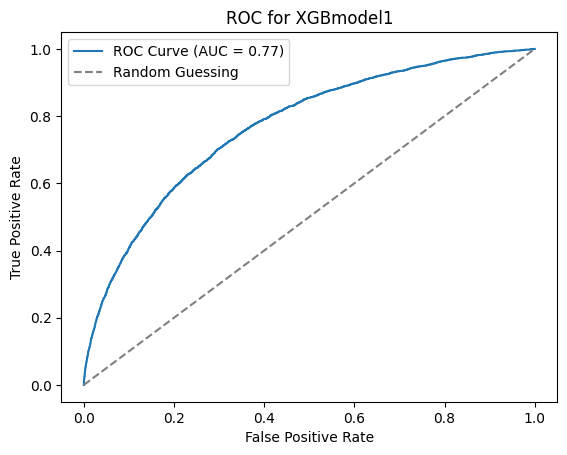

In [599]:
y_true = y_test  # 真实标签
y_scores = y_pred  # 预测的为1的概率

# 计算 ROC 曲线的参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBmodel1')
plt.legend()
plt.show()

In [648]:
y_pred = xgbmodel1.predict(X_test)   #threshold为0.5
cm = confusion_matrix(y_test, y_pred)

true_positive = cm[1, 1]
true_negative = cm[0, 0]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

print('XGBoost:')
print('--------------')
print('True Positive:', true_positive)
print('--------------')
print('True Negative:', true_negative)
print('--------------')
print('False Positive:', false_positive)
print('--------------')
print('False Negative:', false_negative)

XGBoost:
--------------
True Positive: 2594
--------------
True Negative: 33503
--------------
False Positive: 12511
--------------
False Negative: 1294


threshold改为0.3。

In [647]:
y_pred = np.where(xgbmodel1.predict_proba(X_test)[:, 1] >= 0.3, 1, 0)    #threshold为0.3
#y_pred = xgbmodel1.predict(X_test)   #threshold为0.3
cm = confusion_matrix(y_test, y_pred)

true_positive = cm[1, 1]
true_negative = cm[0, 0]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

print('XGBoost:')
print('--------------')
print('True Positive:', true_positive)
print('--------------')
print('True Negative:', true_negative)
print('--------------')
print('False Positive:', false_positive)
print('--------------')
print('False Negative:', false_negative)

XGBoost:
--------------
True Positive: 3446
--------------
True Negative: 19640
--------------
False Positive: 26374
--------------
False Negative: 442


Precision(精确率) = TP / (TP + FP)

所有预测为正的个体中，有多少是对的


Recall(召回率) = TP / (TP + FN)     

所有真实值为正的个体中，有多少是对的

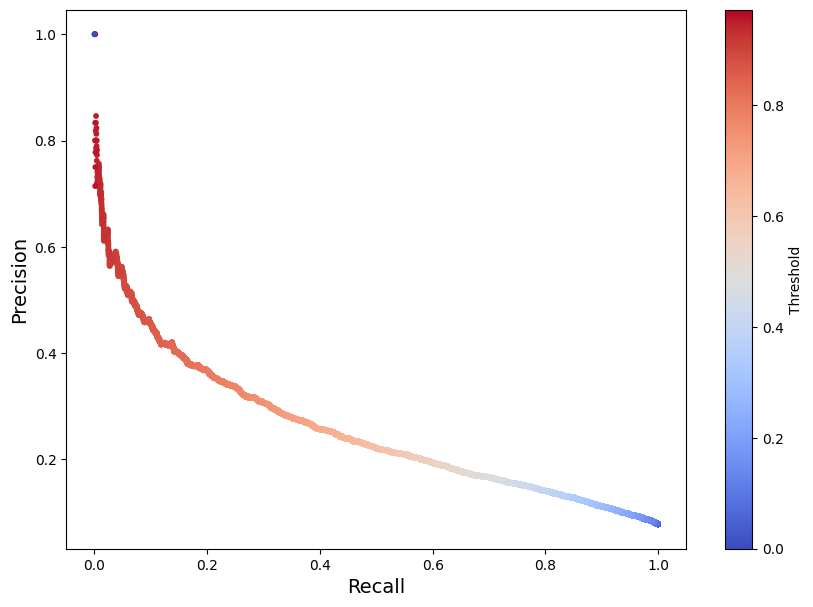

In [640]:
y_scores = xgbmodel1.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [601]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
    'gamma': 0.19949772291032702,
    'learning_rate': 0.06366804652592485,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 0.8798331303185938,
    'scale_pos_weight': 11.750766557645134
}

# 创建 XGBoost 分类器，并使用最佳超参数进行训练
xgbmodel2 = XGBClassifier(**best_params)
xgbmodel2.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgbmodel2.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.7664861705177937


In [602]:
y_pred_proba = xgbmodel2.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.928614,0.071386
1,0.754769,0.245231
2,0.256986,0.743014
3,0.752596,0.247404
4,0.446311,0.553689
...,...,...
49897,0.729305,0.270695
49898,0.758312,0.241688
49899,0.300997,0.699003
49900,0.367116,0.632884


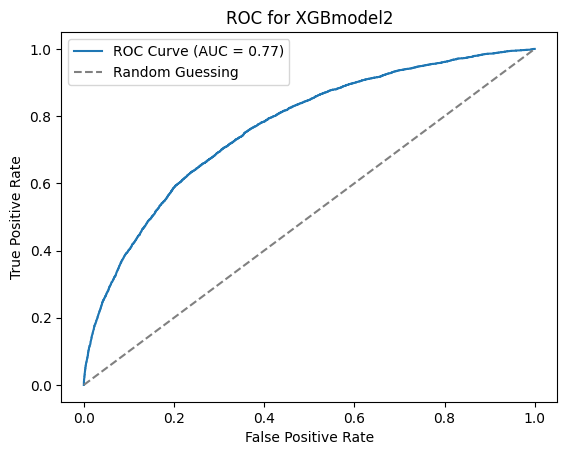

In [603]:
y_true = y_test  # 真实标签
y_scores = y_pred  # 预测的为1的概率

# 计算 ROC 曲线的参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for XGBmodel2')
plt.legend()
plt.show()

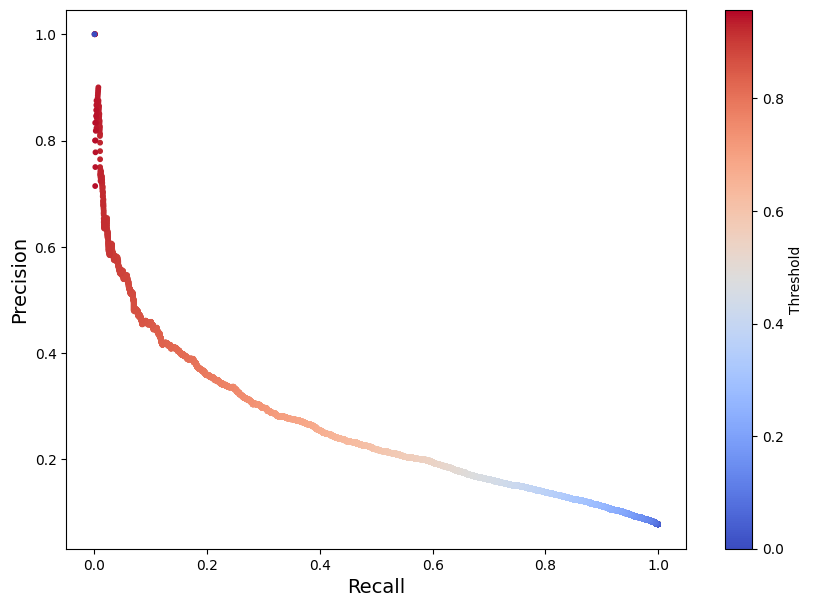

In [641]:
y_scores = xgbmodel2.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

模型换为LightGBM试试。

In [605]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'min_split_gain':0.25560865378490555, 
'learning_rate':0.07461139976709795, 
'max_depth':3, 
'min_child_weight':9, 
'n_estimators':428, 
'reg_alpha':0.0, 
'reg_lambda':0.5304630959073479, 
'subsample':0.7813822517885592,
'scale_pos_weight': 11.750766557645134
}

lgbmmodel1 = lgb.LGBMClassifier(**best_params)
lgbmmodel1.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lgbmmodel1.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.7688017343442262


In [606]:
y_pred_proba = lgbmmodel1.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.885385,0.114615
1,0.722624,0.277376
2,0.265052,0.734948
3,0.660184,0.339816
4,0.471557,0.528443
...,...,...
49897,0.723433,0.276567
49898,0.591561,0.408439
49899,0.341038,0.658962
49900,0.309803,0.690197


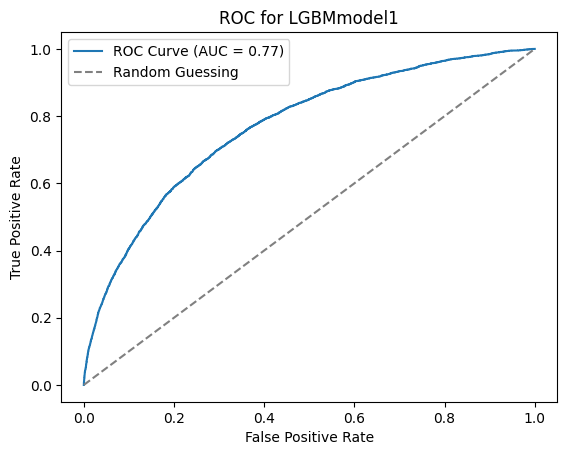

In [607]:
y_true = y_test  # 真实标签
y_scores = y_pred_proba[:, 1]  # 预测的为1的概率

# 计算 ROC 曲线的参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LGBMmodel1')
plt.legend()
plt.show()

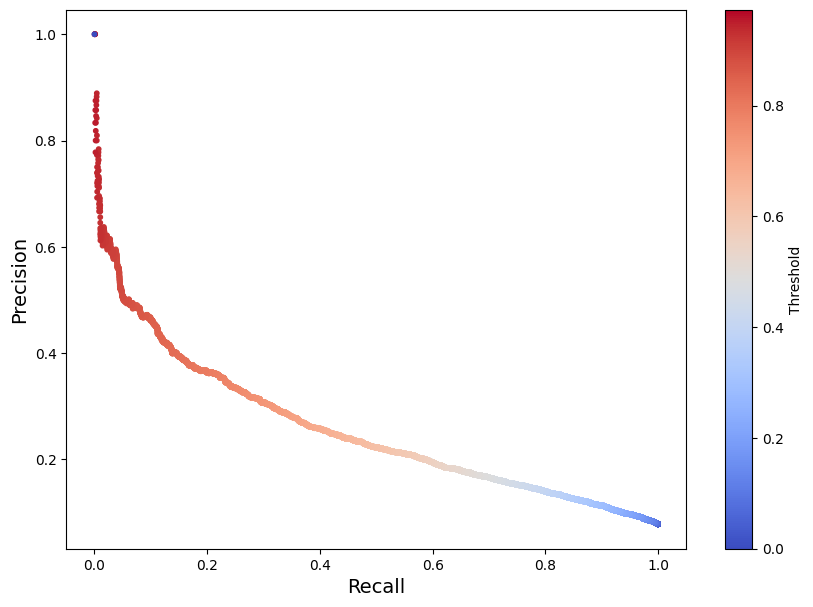

In [642]:
y_scores = lgbmmodel1.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [619]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用贝叶斯优化得到的最佳超参数
best_params = {
'learning_rate': 0.05104629857953324, 
'max_depth': int(8.066583652537123), 
'min_child_weight': int(2.7970640394252375), 
'min_split_gain': 0.5142344384136116, 
'n_estimators': int(336.965827544817), 
'reg_alpha': 0.046450412719997725, 
'reg_lambda': 0.6075448519014384, 
'subsample': 0.5852620618436457,
'scale_pos_weight': 11.750766557645134
}

lgbmmodel2 = lgb.LGBMClassifier(**best_params)
lgbmmodel2.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lgbmmodel2.predict_proba(X_test)[:, 1]

# 计算 AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

AUC:  0.768877949071145


In [620]:
y_pred_proba = lgbmmodel2.predict_proba(X_test)
pd.DataFrame(y_pred_proba)

,0,1
0,0.910215,0.089785
1,0.736739,0.263261
2,0.286621,0.713379
3,0.706063,0.293937
4,0.576510,0.423490
...,...,...
49897,0.621373,0.378627
49898,0.663670,0.336330
49899,0.311031,0.688969
49900,0.431213,0.568787


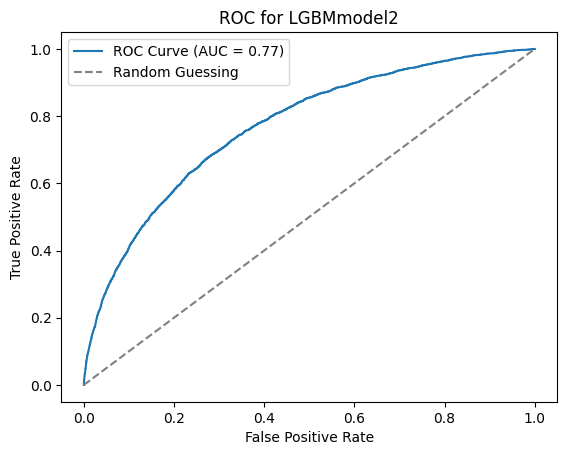

In [621]:
y_true = y_test  # 真实标签
y_scores = y_pred  # 预测的为1的概率

# 计算 ROC 曲线的参数
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LGBMmodel2')
plt.legend()
plt.show()

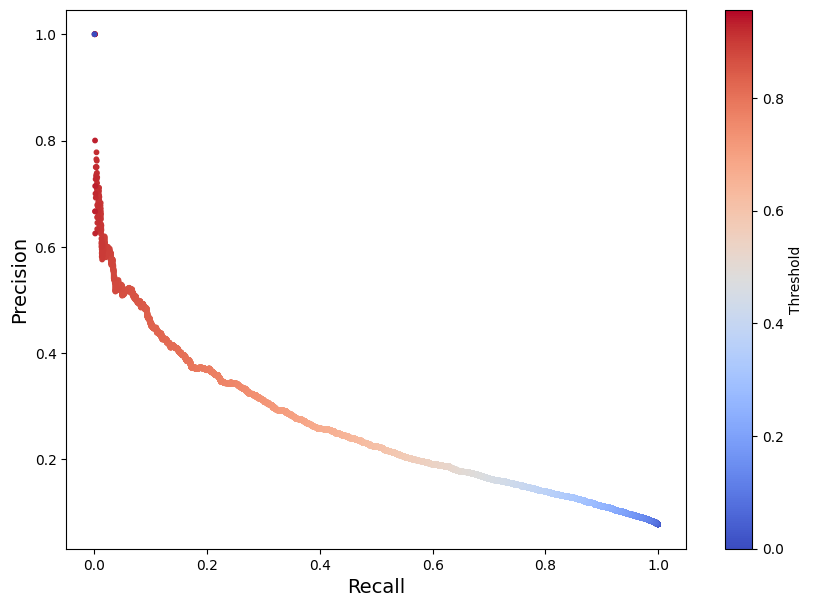

In [643]:
y_scores = lgbmmodel2.predict_proba(X_test)[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_true = y_test
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 将阈值数组的长度增加一，并将最后一个元素设置为0
thresholds = list(thresholds) + [0]

# 绘制Precision-Recall曲线，使用散点图表示，并使用阈值作为颜色
plt.figure(figsize=(10,7))
plt.scatter(recall, precision, c=thresholds, cmap='coolwarm', s=10)  # 调整s参数来改变点的大小
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.colorbar(label='Threshold')
plt.show()

In [644]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### 步骤3.寻找超参 （Bayes Optimization）

以下为Skopt库 (XGB)。

In [ ]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 XGBoost 分类器
model = XGBClassifier()

# 定义超参数的搜索范围
param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'gamma': (0.0, 0.5),
    'min_child_weight': (1, 10),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

# 使用贝叶斯优化进行超参数优化
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, scoring='roc_auc', cv=10, n_iter=50)

# 添加进度条显示
with tqdm(total=50) as pbar:  # 设置进度条总长度为 50
    def on_step(optim_result):
        pbar.update(1)  # 每完成一次优化步骤，更新进度条进度

    bayes_search.fit(X_train, y_train, callback=on_step)

# 输出贝叶斯优化的结果
print("Bayesian Optimization - Best Parameters: ", bayes_search.best_params_)
print("Bayesian Optimization - Best Score: ", bayes_search.best_score_)

100%|██████████| 50/50 [28:34:53<00:00, 2057.88s/it]   

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.25560865378490555), ('learning_rate', 0.07461139976709795), ('max_depth', 3), ('min_child_weight', 9), ('n_estimators', 428), ('reg_alpha', 0.0), ('reg_lambda', 0.5304630959073479), ('subsample', 0.7813822517885592)])
Bayesian Optimization - Best Score:  0.779785101630243


### Skopt Output（XGB）。

#### Output1:

100%|██████████| 50/50 [13:36:18<00:00, 979.57s/it]   

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.19949772291032702), 
                                                       ('learning_rate', 0.06366804652592485), 
                                                       ('max_depth', 5), 
                                                       ('n_estimators', 300), 
                                                       ('subsample', 0.8798331303185938)])
                                                       
Bayesian Optimization - Best Score:  0.7792223470916406

AUC:  0.7689825647535078


#### Output2:

100%|██████████| 50/50 [28:34:53<00:00, 2057.88s/it]

Bayesian Optimization - Best Parameters:  OrderedDict([('gamma', 0.25560865378490555), 
                                                        ('learning_rate', 0.07461139976709795), 
                                                        ('max_depth', 3), 
                                                        ('min_child_weight', 9), 
                                                        ('n_estimators', 428), 
                                                        ('reg_alpha', 0.0), 
                                                        ('reg_lambda', 0.5304630959073479), 
                                                        ('subsample', 0.7813822517885592)])

Bayesian Optimization - Best Score:  0.779785101630243

AUC:  0.7664861705177937

以下为bayes_opt库 (XGB + LGBM)。

In [625]:
# 划分训练集和测试集-XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数的搜索范围
param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'gamma': (0.0, 0.5),
    'min_child_weight': (1, 10),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

# 定义优化目标函数
def xgb_optimization(learning_rate, n_estimators, max_depth, subsample, gamma, min_child_weight, reg_alpha, reg_lambda):
    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        subsample=subsample,
        gamma=gamma,
        min_child_weight=int(min_child_weight),
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# 使用贝叶斯优化进行超参数优化
bayes_search = BayesianOptimization(f=xgb_optimization, pbounds=param_space, random_state=42)
bayes_search.maximize(init_points=5, n_iter=10)

# 输出贝叶斯优化的结果
print("Bayesian Optimization - Best Parameters: ", bayes_search.max['params'])
print("Bayesian Optimization - Best Score: ", bayes_search.max['target'])

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.754     | 0.1873    | 0.1906    | 8.124     | 6.388     | 162.4     | 0.156     | 0.05808   | 0.9331    |
| 2         | 0.7668    | 0.3006    | 0.1445    | 3.144     | 9.729     | 433.0     | 0.2123    | 0.1818    | 0.5917    |
| 3         | 0.7615    | 0.1521    | 0.1097    | 6.024     | 3.621     | 344.7     | 0.1395    | 0.2921    | 0.6832    |
| 4         | 0.7633    | 0.228     | 0.1592    | 4.398     | 5.628     | 337.0     | 0.04645   | 0.6075    | 0.5853    |
| 5         | 0.7366    | 0.03253   | 0.1903    | 9.759     | 8.276     | 221.8     | 0.09767   | 0.6842    | 0.7201    |
| 6         | 0.7425    | 0.3935    | 0.1936    | 6.271     | 9.96      | 482.8     | 0.6569    | 0.8476    | 0.6483    |
| 7         | 0.7673    

In [615]:
# 划分训练集和测试集-LGBMClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 LightGBM 参数空间
param_space = {
    'min_split_gain': (0.0, 1.0),
    'learning_rate': (0.01, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'n_estimators': (100, 500),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0),
    'subsample': (0.5, 1.0)
}

# 定义目标函数
def lgb_objective(min_split_gain, learning_rate, max_depth, min_child_weight, n_estimators,
                  reg_alpha, reg_lambda, subsample):
    params = {
        'min_split_gain': min_split_gain,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'n_estimators': int(n_estimators),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'subsample': subsample
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

# 使用贝叶斯优化进行超参数优化
bayes_optimizer = BayesianOptimization(f=lgb_objective, pbounds=param_space, random_state=42)
bayes_optimizer.maximize(init_points=5, n_iter=10)

# 输出贝叶斯优化的结果
best_params = bayes_optimizer.max['params']
best_auc = bayes_optimizer.max['target']
print("Best Parameters: ", best_params)
print("Best AUC: ", best_auc)

|   iter    |  target   | learni... | max_depth | min_ch... | min_sp... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7665    | 0.04371   | 9.556     | 7.588     | 0.5987    | 162.4     | 0.156     | 0.05808   | 0.9331    |
| 2         | 0.7682    | 0.0641    | 7.373     | 1.185     | 0.9699    | 433.0     | 0.2123    | 0.1818    | 0.5917    |
| 3         | 0.7676    | 0.03738   | 5.723     | 4.888     | 0.2912    | 344.7     | 0.1395    | 0.2921    | 0.6832    |
| 4         | 0.7689    | 0.05105   | 8.067     | 2.797     | 0.5142    | 337.0     | 0.04645   | 0.6075    | 0.5853    |
| 5         | 0.7564    | 0.01585   | 9.54      | 9.691     | 0.8084    | 221.8     | 0.09767   | 0.6842    | 0.7201    |
| 6         | 0.754     | 0.1       | 1.0       | 1.0       | 0.0       | 301.0     | 0.5944    | 0.0       | 0.9221    |
| 7         | 0.7655    

### bayes_opt Output (XGB + LGBM)

#### Output 3 (XGB):

Bayesian Optimization - Best Parameters:   {'gamma': 0.45553110323727575, 
                                            'learning_rate': 0.06900618871869173, 
                                            'max_depth': 3.1766757678175006, 
                                            'min_child_weight': 8.286751918403938, 
                                            'n_estimators': 409.67412539753695, 
                                            'reg_alpha': 0.9265515927692223, 
                                            'reg_lambda': 0.6502942743641044, 
                                            'subsample': 0.6265829684311294}

Bayesian Optimization - Best Score:  0.7686109264294406

#### Output 4 (LGBM):

Best Parameters:  {'learning_rate': 0.05104629857953324, 
                    'max_depth': 8.066583652537123, 
                    'min_child_weight': 2.7970640394252375, 
                    'min_split_gain': 0.5142344384136116, 
                    'n_estimators': 336.965827544817, 
                    'reg_alpha': 0.046450412719997725, 
                    'reg_lambda': 0.6075448519014384, 
                    'subsample': 0.5852620618436457}
                    
Best AUC:  0.7689350025157846

### 4. References

scale_pos_weight: https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets